In [1]:
import os
import numpy as np
import tensorflow as tf

PATH = '/home/jupyter/YogaModel/dataset/'
train_dir = os.path.join(PATH, 'training')
test_dir = os.path.join(PATH, 'testing')

print(train_dir)
print(test_dir)

/home/jupyter/YogaModel/dataset/training
/home/jupyter/YogaModel/dataset/testing


In [2]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [3]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size = BATCH_SIZE,
    image_size=IMG_SIZE
)

Found 4752 files belonging to 107 classes.


2021-11-16 02:43:50.587158: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-16 02:43:50.592289: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

Found 1241 files belonging to 107 classes.


In [5]:
class_names = train_dataset.class_names
print(class_names)

['adho mukha svanasana', 'adho mukha vriksasana', 'agnistambhasana', 'ananda balasana', 'anantasana', 'anjaneyasana', 'ardha bhekasana', 'ardha chandrasana', 'ardha matsyendrasana', 'ardha pincha mayurasana', 'ardha uttanasana', 'ashtanga namaskara', 'astavakrasana', 'baddha konasana', 'bakasana', 'balasana', 'bhairavasana', 'bharadvajasana i', 'bhekasana', 'bhujangasana', 'bhujapidasana', 'bitilasana', 'camatkarasana', 'chakravakasana', 'chaturanga dandasana', 'dandasana', 'dhanurasana', 'durvasasana', 'dwi pada viparita dandasana', 'eka pada koundinyanasana i', 'eka pada koundinyanasana ii', 'eka pada rajakapotasana', 'eka pada rajakapotasana ii', 'ganda bherundasana', 'garbha pindasana', 'garudasana', 'gomukhasana', 'halasana', 'hanumanasana', 'janu sirsasana', 'kapotasana', 'krounchasana', 'kurmasana', 'lolasana', 'makara adho mukha svanasana', 'makarasana', 'malasana', 'marichyasana i', 'marichyasana iii', 'marjaryasana', 'matsyasana', 'mayurasana', 'natarajasana', 'padangusthasan

2021-11-16 02:45:04.126014: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


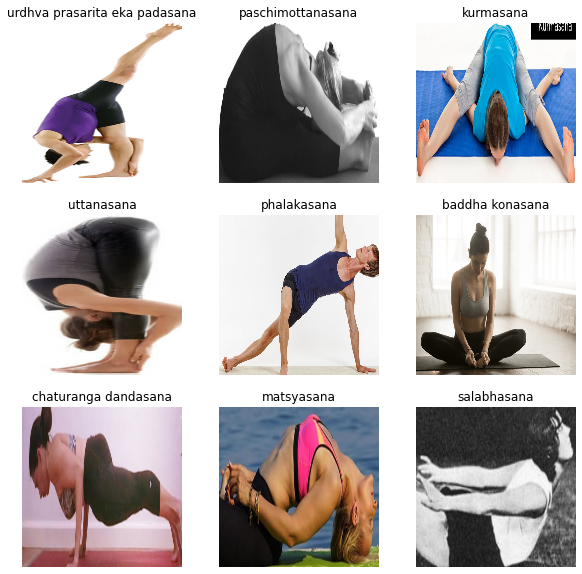

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [7]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 32
Number of test batches: 7


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [9]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
])

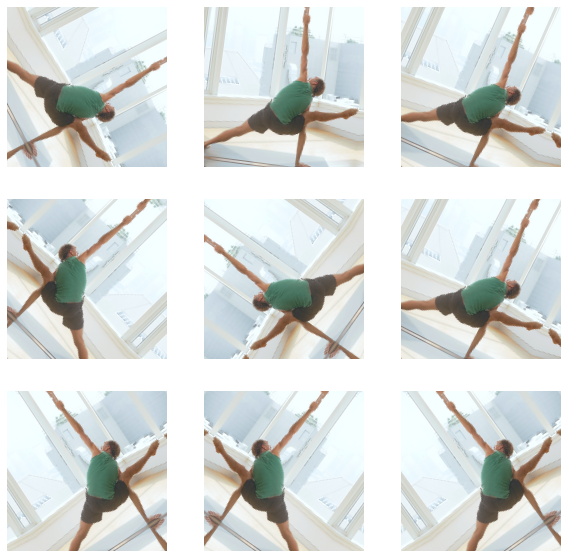

In [10]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [11]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1.0/127.5, offset=-1)

In [12]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

9420800/9406464 [==============================] - 0s 0us/step


In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [14]:
base_model.trainable = False

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [16]:
prediction_layer = tf.keras.layers.Dense(len(class_names))

In [17]:
prediction_batch = prediction_layer(feature_batch_average)

In [18]:
print(prediction_batch.shape)

(32, 107)


In [19]:
inputs = tf.keras.layers.Input(shape=(160,160,3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [22]:
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
    , loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    , metrics = ['accuracy']
)

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [26]:
initial_epochs = 100
losses0, accuracy0 = model.evaluate(validation_dataset)

2021-11-16 03:14:41.411556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


21/32 [==================>...........] - ETA: 2s - loss: 3.5319 - accuracy: 0.1979

2021-11-16 03:14:47.237147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


32/32 [==============================] - 8s 226ms/step - loss: 3.5340 - accuracy: 0.1957


In [27]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/100
  9/149 [>.............................] - ETA: 43s - loss: 3.4270 - accuracy: 0.2257

2021-11-16 03:14:58.755632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/149 [=====================>........] - ETA: 11s - loss: 3.3349 - accuracy: 0.2258

2021-11-16 03:15:29.853825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/149 [======================>.......] - ETA: 10s - loss: 3.3345 - accuracy: 0.2252

2021-11-16 03:15:31.341129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 3.3236 - accuracy: 0.2281

2021-11-16 03:15:41.036506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 03:15:46.846465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 359ms/step - loss: 3.3236 - accuracy: 0.2281 - val_loss: 3.4333 - val_accuracy: 0.2242
Epoch 2/100
 10/149 [=>............................] - ETA: 44s - loss: 3.2376 - accuracy: 0.2438

2021-11-16 03:16:20.764987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 10s - loss: 3.2209 - accuracy: 0.2420

2021-11-16 03:16:51.791009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 3.2192 - accuracy: 0.2423

2021-11-16 03:16:53.341081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 3.2191 - accuracy: 0.2473

2021-11-16 03:17:01.755498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 03:17:07.451740: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 52s 349ms/step - loss: 3.2191 - accuracy: 0.2473 - val_loss: 3.3720 - val_accuracy: 0.2281
Epoch 3/100
  9/149 [>.............................] - ETA: 39s - loss: 3.1225 - accuracy: 0.2847

2021-11-16 03:17:42.368441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 10s - loss: 3.1610 - accuracy: 0.2580

2021-11-16 03:18:13.880149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 3.1547 - accuracy: 0.2587

2021-11-16 03:18:15.390326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 3.1522 - accuracy: 0.2578

2021-11-16 03:18:24.593657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 03:18:30.639507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 358ms/step - loss: 3.1522 - accuracy: 0.2578 - val_loss: 3.3326 - val_accuracy: 0.2380
Epoch 4/100
 10/149 [=>............................] - ETA: 42s - loss: 3.0561 - accuracy: 0.2750

2021-11-16 03:18:36.476648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 10s - loss: 3.0394 - accuracy: 0.2840

2021-11-16 03:19:07.131925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 3.0395 - accuracy: 0.2812

2021-11-16 03:19:08.770459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 3.0446 - accuracy: 0.2824

2021-11-16 03:19:18.035407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 03:19:23.816225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 53s 354ms/step - loss: 3.0446 - accuracy: 0.2824 - val_loss: 3.2613 - val_accuracy: 0.2439
Epoch 5/100
  9/149 [>.............................] - ETA: 45s - loss: 2.9727 - accuracy: 0.3194

2021-11-16 03:19:58.583794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 11s - loss: 2.9757 - accuracy: 0.2959

2021-11-16 03:20:30.418192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 2.9725 - accuracy: 0.2982

2021-11-16 03:20:32.054934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 2.9703 - accuracy: 0.2995

2021-11-16 03:20:41.368131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 03:20:47.517741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 55s 364ms/step - loss: 2.9703 - accuracy: 0.2995 - val_loss: 3.1942 - val_accuracy: 0.2527
Epoch 6/100
 10/149 [=>............................] - ETA: 40s - loss: 2.9536 - accuracy: 0.3094

2021-11-16 03:20:53.119686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 11s - loss: 2.9012 - accuracy: 0.3125

2021-11-16 03:21:25.058200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 2.9047 - accuracy: 0.3109

2021-11-16 03:21:26.799330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 2.8962 - accuracy: 0.3136

2021-11-16 03:21:35.932249: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 03:21:41.529322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 359ms/step - loss: 2.8962 - accuracy: 0.3136 - val_loss: 3.1300 - val_accuracy: 0.2734
Epoch 7/100
 10/149 [=>............................] - ETA: 44s - loss: 2.9130 - accuracy: 0.2781

2021-11-16 03:22:15.167086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 11s - loss: 2.8503 - accuracy: 0.3142

2021-11-16 03:22:46.726859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 2.8429 - accuracy: 0.3173

2021-11-16 03:22:48.506738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 2.8407 - accuracy: 0.3165

2021-11-16 03:22:57.466364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 03:23:03.323692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 358ms/step - loss: 2.8407 - accuracy: 0.3165 - val_loss: 3.1003 - val_accuracy: 0.2812
Epoch 8/100
 10/149 [=>............................] - ETA: 42s - loss: 2.7583 - accuracy: 0.3281

2021-11-16 03:23:37.019723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 11s - loss: 2.7873 - accuracy: 0.3211

2021-11-16 03:24:09.223599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 2.7860 - accuracy: 0.3215

2021-11-16 03:24:10.784359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 2.7753 - accuracy: 0.3268

2021-11-16 03:24:19.720067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 03:24:25.303625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 361ms/step - loss: 2.7753 - accuracy: 0.3268 - val_loss: 3.0898 - val_accuracy: 0.2793
Epoch 9/100
  9/149 [>.............................] - ETA: 40s - loss: 2.5931 - accuracy: 0.3854

2021-11-16 03:24:58.707076: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 11s - loss: 2.6911 - accuracy: 0.3581

2021-11-16 03:25:30.791501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 2.6943 - accuracy: 0.3573

2021-11-16 03:25:32.410369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 2.6909 - accuracy: 0.3594

2021-11-16 03:25:41.528046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 03:25:47.269909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 358ms/step - loss: 2.6909 - accuracy: 0.3594 - val_loss: 3.0377 - val_accuracy: 0.2911
Epoch 10/100
  9/149 [>.............................] - ETA: 46s - loss: 2.5520 - accuracy: 0.4236

2021-11-16 03:25:52.971652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 11s - loss: 2.6231 - accuracy: 0.3822

2021-11-16 03:26:25.400919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 2.6239 - accuracy: 0.3811 

2021-11-16 03:26:26.988390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 2.6393 - accuracy: 0.3748

2021-11-16 03:26:36.200267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 03:26:42.111212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 55s 368ms/step - loss: 2.6393 - accuracy: 0.3748 - val_loss: 3.0122 - val_accuracy: 0.2871
Epoch 11/100
 10/149 [=>............................] - ETA: 42s - loss: 2.6290 - accuracy: 0.3938

2021-11-16 03:27:14.592170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 10s - loss: 2.6114 - accuracy: 0.3725

2021-11-16 03:27:45.502082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 2.6121 - accuracy: 0.3737

2021-11-16 03:27:47.051891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 2.6078 - accuracy: 0.3773

2021-11-16 03:27:55.674707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 03:28:01.776926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 53s 356ms/step - loss: 2.6078 - accuracy: 0.3773 - val_loss: 2.9612 - val_accuracy: 0.3029
Epoch 12/100
 10/149 [=>............................] - ETA: 41s - loss: 2.5513 - accuracy: 0.4219

2021-11-16 03:28:36.449044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 10s - loss: 2.5495 - accuracy: 0.3880

2021-11-16 03:29:07.629417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 2.5489 - accuracy: 0.3888

2021-11-16 03:29:09.114831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 2.5572 - accuracy: 0.3870

2021-11-16 03:29:17.714956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 03:29:23.563567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 53s 352ms/step - loss: 2.5572 - accuracy: 0.3870 - val_loss: 2.9525 - val_accuracy: 0.2960
Epoch 13/100
  9/149 [>.............................] - ETA: 42s - loss: 2.4901 - accuracy: 0.4306

2021-11-16 03:29:58.371415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 11s - loss: 2.4861 - accuracy: 0.4060

2021-11-16 03:30:30.839497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 2.4899 - accuracy: 0.4044

2021-11-16 03:30:32.445365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 2.4942 - accuracy: 0.4040

2021-11-16 03:30:41.722687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 03:30:47.452581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 55s 368ms/step - loss: 2.4942 - accuracy: 0.4040 - val_loss: 2.9017 - val_accuracy: 0.3137
Epoch 14/100
 10/149 [=>............................] - ETA: 43s - loss: 2.4773 - accuracy: 0.4125

2021-11-16 03:31:20.496042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 11s - loss: 2.4518 - accuracy: 0.4079

2021-11-16 03:31:52.613004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 2.4519 - accuracy: 0.4089

2021-11-16 03:31:54.261141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 2.4492 - accuracy: 0.4106

2021-11-16 03:32:03.475971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 03:32:09.559970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 10s - loss: 2.2382 - accuracy: 0.4643

2021-11-16 03:37:46.350284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 2.2346 - accuracy: 0.4672

2021-11-16 03:37:48.018333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 2.2374 - accuracy: 0.4644

2021-11-16 03:37:57.130313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 03:38:02.835135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 53s 355ms/step - loss: 2.2374 - accuracy: 0.4644 - val_loss: 2.7585 - val_accuracy: 0.3343
Epoch 20/100
 10/149 [=>............................] - ETA: 42s - loss: 2.2014 - accuracy: 0.4406

2021-11-16 03:38:36.821725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/149 [=====================>........] - ETA: 11s - loss: 2.1961 - accuracy: 0.4707

2021-11-16 03:39:07.910526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/149 [======================>.......] - ETA: 10s - loss: 2.2023 - accuracy: 0.4685

2021-11-16 03:39:09.503265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 2.2064 - accuracy: 0.4665

2021-11-16 03:39:19.164435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 03:39:24.997461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 359ms/step - loss: 2.2064 - accuracy: 0.4665 - val_loss: 2.7069 - val_accuracy: 0.3510
Epoch 21/100
 10/149 [=>............................] - ETA: 43s - loss: 2.1776 - accuracy: 0.4719

2021-11-16 03:39:30.889343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 10s - loss: 2.1713 - accuracy: 0.4751

2021-11-16 03:40:01.597629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 2.1665 - accuracy: 0.4762

2021-11-16 03:40:03.214282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 2.1685 - accuracy: 0.4739

2021-11-16 03:40:12.312302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 03:40:18.095521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 53s 353ms/step - loss: 2.1685 - accuracy: 0.4739 - val_loss: 2.6862 - val_accuracy: 0.3481
Epoch 22/100
 10/149 [=>............................] - ETA: 44s - loss: 2.1472 - accuracy: 0.4906

2021-11-16 03:40:52.838656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 11s - loss: 2.1538 - accuracy: 0.4848

2021-11-16 03:41:24.319947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 2.1576 - accuracy: 0.4831

2021-11-16 03:41:26.070624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 2.1672 - accuracy: 0.4809

2021-11-16 03:41:35.349642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 03:41:40.917971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 358ms/step - loss: 2.1672 - accuracy: 0.4809 - val_loss: 2.6878 - val_accuracy: 0.3550
Epoch 23/100
 10/149 [=>............................] - ETA: 45s - loss: 2.1345 - accuracy: 0.4875

2021-11-16 03:41:46.763903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/149 [=====================>........] - ETA: 11s - loss: 2.1131 - accuracy: 0.4909

2021-11-16 03:42:16.623476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/149 [======================>.......] - ETA: 10s - loss: 2.1095 - accuracy: 0.4948

2021-11-16 03:42:18.122685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 2.1163 - accuracy: 0.4886

2021-11-16 03:42:28.123773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 03:42:34.089693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 356ms/step - loss: 2.1163 - accuracy: 0.4886 - val_loss: 2.6814 - val_accuracy: 0.3559
Epoch 24/100
 10/149 [=>............................] - ETA: 45s - loss: 2.0993 - accuracy: 0.5219

2021-11-16 03:43:08.594392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 10s - loss: 2.0975 - accuracy: 0.4972

2021-11-16 03:43:38.682598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 2.1012 - accuracy: 0.4971

2021-11-16 03:43:40.283695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 2.0939 - accuracy: 0.5002

2021-11-16 03:43:49.309822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 03:43:55.496640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 53s 352ms/step - loss: 2.0939 - accuracy: 0.5002 - val_loss: 2.6777 - val_accuracy: 0.3520
Epoch 25/100
  8/149 [>.............................] - ETA: 45s - loss: 2.0631 - accuracy: 0.5078

2021-11-16 03:44:30.076186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/149 [=====================>........] - ETA: 11s - loss: 2.0835 - accuracy: 0.4950

2021-11-16 03:45:02.032509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/149 [======================>.......] - ETA: 9s - loss: 2.0794 - accuracy: 0.4979 

2021-11-16 03:45:03.666311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 2.0829 - accuracy: 0.4983

2021-11-16 03:45:12.610303: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 03:45:18.261752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 358ms/step - loss: 2.0829 - accuracy: 0.4983 - val_loss: 2.6344 - val_accuracy: 0.3658
Epoch 26/100
  9/149 [>.............................] - ETA: 45s - loss: 2.0531 - accuracy: 0.4896

2021-11-16 03:45:24.240022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 10s - loss: 2.0091 - accuracy: 0.5183

2021-11-16 03:45:56.093651: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/149 [======================>.......] - ETA: 10s - loss: 2.0052 - accuracy: 0.5194

2021-11-16 03:45:57.231338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 2.0147 - accuracy: 0.5168

2021-11-16 03:46:07.309462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 03:46:13.057636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 55s 364ms/step - loss: 2.0147 - accuracy: 0.5168 - val_loss: 2.6149 - val_accuracy: 0.3648
Epoch 27/100
 10/149 [=>............................] - ETA: 43s - loss: 2.1389 - accuracy: 0.4875

2021-11-16 03:46:19.083420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/149 [=====================>........] - ETA: 11s - loss: 2.0333 - accuracy: 0.5028

2021-11-16 03:46:49.974232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/149 [======================>.......] - ETA: 9s - loss: 2.0360 - accuracy: 0.5016

2021-11-16 03:46:51.518149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 2.0316 - accuracy: 0.5004

2021-11-16 03:47:01.221284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 03:47:06.971683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 359ms/step - loss: 2.0316 - accuracy: 0.5004 - val_loss: 2.6217 - val_accuracy: 0.3559
Epoch 28/100
 10/149 [=>............................] - ETA: 40s - loss: 1.9646 - accuracy: 0.5344

2021-11-16 03:47:40.656573: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 10s - loss: 1.9736 - accuracy: 0.5232

2021-11-16 03:48:12.425324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.9801 - accuracy: 0.5199

2021-11-16 03:48:13.971355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.9659 - accuracy: 0.5242

2021-11-16 03:48:22.927982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 03:48:28.731529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 359ms/step - loss: 1.9659 - accuracy: 0.5242 - val_loss: 2.6081 - val_accuracy: 0.3727
Epoch 29/100
 10/149 [=>............................] - ETA: 41s - loss: 1.9533 - accuracy: 0.5406

2021-11-16 03:48:34.691083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 11s - loss: 1.9461 - accuracy: 0.5224

2021-11-16 03:49:07.080961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.9567 - accuracy: 0.5188

2021-11-16 03:49:08.686096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.9511 - accuracy: 0.5194

2021-11-16 03:49:17.915714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 03:49:23.432682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 55s 363ms/step - loss: 1.9511 - accuracy: 0.5194 - val_loss: 2.5881 - val_accuracy: 0.3786
Epoch 30/100
  9/149 [>.............................] - ETA: 42s - loss: 1.9570 - accuracy: 0.5104

2021-11-16 03:49:56.568583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 11s - loss: 1.9526 - accuracy: 0.5224

2021-11-16 03:50:28.825427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.9531 - accuracy: 0.5209

2021-11-16 03:50:30.434532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.9412 - accuracy: 0.5196

2021-11-16 03:50:39.667239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 03:50:45.431092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 360ms/step - loss: 1.9412 - accuracy: 0.5196 - val_loss: 2.5236 - val_accuracy: 0.3894
Epoch 31/100
 10/149 [=>............................] - ETA: 41s - loss: 1.8212 - accuracy: 0.5594

2021-11-16 03:51:18.449891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 10s - loss: 1.9078 - accuracy: 0.5321

2021-11-16 03:51:49.391487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.9082 - accuracy: 0.5336

2021-11-16 03:51:50.952264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.9118 - accuracy: 0.5324

2021-11-16 03:51:59.400630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 03:52:05.211939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 52s 349ms/step - loss: 1.9118 - accuracy: 0.5324 - val_loss: 2.5425 - val_accuracy: 0.3599
Epoch 32/100
  5/149 [>.............................] - ETA: 43s - loss: 1.9414 - accuracy: 0.5312

2021-11-16 03:57:57.605727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 53s 352ms/step - loss: 1.7984 - accuracy: 0.5612 - val_loss: 2.4874 - val_accuracy: 0.3913
Epoch 37/100
 10/149 [=>............................] - ETA: 42s - loss: 1.8471 - accuracy: 0.5562

2021-11-16 03:58:03.228862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 10s - loss: 1.8042 - accuracy: 0.5600

2021-11-16 03:58:34.681662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.7981 - accuracy: 0.5620

2021-11-16 03:58:36.328010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.8049 - accuracy: 0.5602

2021-11-16 03:58:45.700258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 03:58:51.659117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 360ms/step - loss: 1.8049 - accuracy: 0.5602 - val_loss: 2.5292 - val_accuracy: 0.3776
Epoch 38/100
 10/149 [=>............................] - ETA: 40s - loss: 1.8672 - accuracy: 0.5531

2021-11-16 03:59:24.879757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 10s - loss: 1.7620 - accuracy: 0.5788

2021-11-16 03:59:55.888109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 8s - loss: 1.7674 - accuracy: 0.5780

2021-11-16 03:59:57.329578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.7766 - accuracy: 0.5747

2021-11-16 04:00:06.299167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:00:12.462559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 53s 351ms/step - loss: 1.7766 - accuracy: 0.5747 - val_loss: 2.4977 - val_accuracy: 0.3835
Epoch 39/100
 10/149 [=>............................] - ETA: 44s - loss: 1.8688 - accuracy: 0.5875

2021-11-16 04:00:17.911768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/149 [=====================>........] - ETA: 10s - loss: 1.7609 - accuracy: 0.5767

2021-11-16 04:00:48.196662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/149 [======================>.......] - ETA: 9s - loss: 1.7592 - accuracy: 0.5772

2021-11-16 04:00:49.721568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.7635 - accuracy: 0.5755

2021-11-16 04:00:59.194874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:01:04.823746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 53s 351ms/step - loss: 1.7635 - accuracy: 0.5755 - val_loss: 2.4967 - val_accuracy: 0.3845
Epoch 40/100
 10/149 [=>............................] - ETA: 43s - loss: 1.7562 - accuracy: 0.5875

2021-11-16 04:01:39.749352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 11s - loss: 1.7470 - accuracy: 0.5733

2021-11-16 04:02:11.175415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.7479 - accuracy: 0.5715

2021-11-16 04:02:12.827443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.7336 - accuracy: 0.5745

2021-11-16 04:02:22.036828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:02:27.815708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 360ms/step - loss: 1.7336 - accuracy: 0.5745 - val_loss: 2.4512 - val_accuracy: 0.3992
Epoch 41/100
  9/149 [>.............................] - ETA: 43s - loss: 1.7168 - accuracy: 0.5556

2021-11-16 04:03:01.605647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 11s - loss: 1.7061 - accuracy: 0.5877

2021-11-16 04:03:33.643465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.7095 - accuracy: 0.5861

2021-11-16 04:03:35.282678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.7104 - accuracy: 0.5880

2021-11-16 04:03:44.607165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:03:50.315873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 55s 363ms/step - loss: 1.7104 - accuracy: 0.5880 - val_loss: 2.4810 - val_accuracy: 0.3864
Epoch 42/100
  9/149 [>.............................] - ETA: 42s - loss: 1.6743 - accuracy: 0.5764

2021-11-16 04:04:23.421382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 10s - loss: 1.7029 - accuracy: 0.5808

2021-11-16 04:04:54.701487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.7070 - accuracy: 0.5810

2021-11-16 04:04:56.340742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.7013 - accuracy: 0.5821

2021-11-16 04:05:05.583293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:05:11.551540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 358ms/step - loss: 1.7013 - accuracy: 0.5821 - val_loss: 2.4308 - val_accuracy: 0.3982
Epoch 43/100
 10/149 [=>............................] - ETA: 45s - loss: 1.6478 - accuracy: 0.6281

2021-11-16 04:05:45.567993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 10s - loss: 1.6915 - accuracy: 0.5940

2021-11-16 04:06:16.886361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.6913 - accuracy: 0.5938

2021-11-16 04:06:18.520848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.6842 - accuracy: 0.5955

2021-11-16 04:06:27.547150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:06:33.027562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 357ms/step - loss: 1.6842 - accuracy: 0.5955 - val_loss: 2.4727 - val_accuracy: 0.3953
Epoch 44/100
 10/149 [=>............................] - ETA: 40s - loss: 1.7145 - accuracy: 0.5813

2021-11-16 04:07:07.140374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 10s - loss: 1.6552 - accuracy: 0.6034

2021-11-16 04:07:38.223209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.6531 - accuracy: 0.6051

2021-11-16 04:07:39.916907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.6518 - accuracy: 0.6040

2021-11-16 04:07:48.936389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:07:54.648214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 53s 352ms/step - loss: 1.6518 - accuracy: 0.6040 - val_loss: 2.4477 - val_accuracy: 0.3923
Epoch 45/100
 10/149 [=>............................] - ETA: 41s - loss: 1.7269 - accuracy: 0.5656

2021-11-16 04:08:29.140523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 10s - loss: 1.6739 - accuracy: 0.5860

2021-11-16 04:09:00.620554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/149 [======================>.......] - ETA: 9s - loss: 1.6760 - accuracy: 0.5852 

2021-11-16 04:09:02.000676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.6685 - accuracy: 0.5859

2021-11-16 04:09:11.543767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:09:17.515583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 360ms/step - loss: 1.6685 - accuracy: 0.5859 - val_loss: 2.4173 - val_accuracy: 0.3933
Epoch 46/100
 10/149 [=>............................] - ETA: 43s - loss: 1.6525 - accuracy: 0.5719

2021-11-16 04:09:23.365506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 10s - loss: 1.6568 - accuracy: 0.5915

2021-11-16 04:09:53.463172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.6570 - accuracy: 0.5927

2021-11-16 04:09:54.900475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.6449 - accuracy: 0.5962

2021-11-16 04:10:03.499917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:10:09.082936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 51s 341ms/step - loss: 1.6449 - accuracy: 0.5962 - val_loss: 2.4218 - val_accuracy: 0.3953
Epoch 47/100
  9/149 [>.............................] - ETA: 44s - loss: 1.6840 - accuracy: 0.5903

2021-11-16 04:10:14.649643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/149 [=====================>........] - ETA: 11s - loss: 1.6608 - accuracy: 0.5890

2021-11-16 04:10:45.415092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.6586 - accuracy: 0.5903

2021-11-16 04:10:47.267359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.6445 - accuracy: 0.5957

2021-11-16 04:10:56.704794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:11:02.431720: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 357ms/step - loss: 1.6445 - accuracy: 0.5957 - val_loss: 2.4085 - val_accuracy: 0.4071
Epoch 48/100
 10/149 [=>............................] - ETA: 41s - loss: 1.5836 - accuracy: 0.6094

2021-11-16 04:11:36.393259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 10s - loss: 1.6330 - accuracy: 0.6004

2021-11-16 04:12:07.798556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.6323 - accuracy: 0.6012

2021-11-16 04:12:09.462330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.6241 - accuracy: 0.6040

2021-11-16 04:12:18.856650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:12:24.636735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 360ms/step - loss: 1.6241 - accuracy: 0.6040 - val_loss: 2.4204 - val_accuracy: 0.4041
Epoch 49/100
 10/149 [=>............................] - ETA: 44s - loss: 1.5958 - accuracy: 0.6187

2021-11-16 04:12:30.660860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 10s - loss: 1.5989 - accuracy: 0.6098

2021-11-16 04:13:02.007878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 9s - loss: 1.5978 - accuracy: 0.6090

2021-11-16 04:13:03.660574: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.5978 - accuracy: 0.6090

2021-11-16 04:13:12.396241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:13:18.120002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 53s 356ms/step - loss: 1.5978 - accuracy: 0.6090 - val_loss: 2.3776 - val_accuracy: 0.4081
Epoch 50/100
 10/149 [=>............................] - ETA: 41s - loss: 1.5145 - accuracy: 0.6406

2021-11-16 04:13:24.009245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/149 [=====================>........] - ETA: 11s - loss: 1.5726 - accuracy: 0.6126

2021-11-16 04:13:55.072175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/149 [======================>.......] - ETA: 10s - loss: 1.5731 - accuracy: 0.6131

2021-11-16 04:13:56.734129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.5849 - accuracy: 0.6101

2021-11-16 04:14:06.463805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:14:12.071350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 358ms/step - loss: 1.5849 - accuracy: 0.6101 - val_loss: 2.4040 - val_accuracy: 0.4081
Epoch 51/100
  9/149 [>.............................] - ETA: 43s - loss: 1.5905 - accuracy: 0.6076

2021-11-16 04:14:45.877481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/149 [=====================>........] - ETA: 10s - loss: 1.5603 - accuracy: 0.6209

2021-11-16 04:15:17.634149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.5598 - accuracy: 0.6224

2021-11-16 04:15:19.103348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.5598 - accuracy: 0.6221

2021-11-16 04:15:28.436049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:15:34.096870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 359ms/step - loss: 1.5598 - accuracy: 0.6221 - val_loss: 2.4087 - val_accuracy: 0.4081
Epoch 52/100
 10/149 [=>............................] - ETA: 44s - loss: 1.6239 - accuracy: 0.6062

2021-11-16 04:16:07.931129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 10s - loss: 1.5326 - accuracy: 0.6308

2021-11-16 04:16:38.474216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.5397 - accuracy: 0.6303

2021-11-16 04:16:39.987355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.5368 - accuracy: 0.6294

2021-11-16 04:16:49.140635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:16:54.904460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 53s 351ms/step - loss: 1.5368 - accuracy: 0.6294 - val_loss: 2.4486 - val_accuracy: 0.3933
Epoch 53/100
 10/149 [=>............................] - ETA: 44s - loss: 1.5407 - accuracy: 0.6562

2021-11-16 04:17:00.733229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 10s - loss: 1.5370 - accuracy: 0.6175

2021-11-16 04:17:32.336879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/149 [======================>.......] - ETA: 10s - loss: 1.5370 - accuracy: 0.6183

2021-11-16 04:17:33.373550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.5546 - accuracy: 0.6092

2021-11-16 04:17:43.112260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:17:48.939611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 361ms/step - loss: 1.5546 - accuracy: 0.6092 - val_loss: 2.3680 - val_accuracy: 0.4022
Epoch 54/100
  9/149 [>.............................] - ETA: 42s - loss: 1.5926 - accuracy: 0.6007

2021-11-16 04:17:54.903001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 10s - loss: 1.5509 - accuracy: 0.6217

2021-11-16 04:18:26.355471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 9s - loss: 1.5507 - accuracy: 0.6213

2021-11-16 04:18:27.937507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.5394 - accuracy: 0.6256

2021-11-16 04:18:37.036295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:18:42.661847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 53s 352ms/step - loss: 1.5394 - accuracy: 0.6256 - val_loss: 2.3975 - val_accuracy: 0.3963
Epoch 55/100
 10/149 [=>............................] - ETA: 43s - loss: 1.5045 - accuracy: 0.6313

2021-11-16 04:19:16.776613: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 11s - loss: 1.5018 - accuracy: 0.6319

2021-11-16 04:19:48.592863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.5018 - accuracy: 0.6335

2021-11-16 04:19:49.997658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.4969 - accuracy: 0.6324

2021-11-16 04:19:58.722074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:20:04.555364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 357ms/step - loss: 1.4969 - accuracy: 0.6324 - val_loss: 2.3903 - val_accuracy: 0.4022
Epoch 56/100
  9/149 [>.............................] - ETA: 43s - loss: 1.5000 - accuracy: 0.6319

2021-11-16 04:20:10.470418: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 11s - loss: 1.5213 - accuracy: 0.6203

2021-11-16 04:20:42.146880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 9s - loss: 1.5120 - accuracy: 0.6218

2021-11-16 04:20:43.636992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.5165 - accuracy: 0.6168

2021-11-16 04:20:52.204844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:20:57.890684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 53s 353ms/step - loss: 1.5165 - accuracy: 0.6168 - val_loss: 2.3545 - val_accuracy: 0.4130
Epoch 57/100
 10/149 [=>............................] - ETA: 41s - loss: 1.4658 - accuracy: 0.6469

2021-11-16 04:21:03.491734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 10s - loss: 1.4896 - accuracy: 0.6341

2021-11-16 04:21:34.895313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.4900 - accuracy: 0.6343

2021-11-16 04:21:36.484205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.4796 - accuracy: 0.6368

2021-11-16 04:21:45.498160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:21:51.202978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 357ms/step - loss: 1.4796 - accuracy: 0.6368 - val_loss: 2.3655 - val_accuracy: 0.4061
Epoch 58/100
 10/149 [=>............................] - ETA: 47s - loss: 1.5612 - accuracy: 0.6313

2021-11-16 04:22:25.627452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 11s - loss: 1.4857 - accuracy: 0.6408

2021-11-16 04:22:57.914683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.4834 - accuracy: 0.6409 

2021-11-16 04:22:59.533931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.4741 - accuracy: 0.6399

2021-11-16 04:23:08.445523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:23:14.375094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 55s 363ms/step - loss: 1.4741 - accuracy: 0.6399 - val_loss: 2.3714 - val_accuracy: 0.4022
Epoch 59/100
 10/149 [=>............................] - ETA: 42s - loss: 1.4709 - accuracy: 0.6281

2021-11-16 04:23:47.256928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/149 [=====================>........] - ETA: 11s - loss: 1.4746 - accuracy: 0.6409

2021-11-16 04:24:18.887981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/149 [======================>.......] - ETA: 9s - loss: 1.4772 - accuracy: 0.6426 

2021-11-16 04:24:20.502809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.4762 - accuracy: 0.6412

2021-11-16 04:24:29.788532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:24:35.503053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 359ms/step - loss: 1.4762 - accuracy: 0.6412 - val_loss: 2.3640 - val_accuracy: 0.4061
Epoch 60/100
 10/149 [=>............................] - ETA: 39s - loss: 1.4981 - accuracy: 0.6219

2021-11-16 04:25:09.001235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/149 [=====================>........] - ETA: 11s - loss: 1.4539 - accuracy: 0.6423

2021-11-16 04:25:40.458982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/149 [======================>.......] - ETA: 9s - loss: 1.4576 - accuracy: 0.6416 

2021-11-16 04:25:42.038428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.4697 - accuracy: 0.6380

2021-11-16 04:25:51.257891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:25:56.906754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 356ms/step - loss: 1.4697 - accuracy: 0.6380 - val_loss: 2.3446 - val_accuracy: 0.4120
Epoch 61/100
  9/149 [>.............................] - ETA: 40s - loss: 1.4274 - accuracy: 0.6597

2021-11-16 04:26:30.910882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 10s - loss: 1.4400 - accuracy: 0.6532

2021-11-16 04:27:01.313755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 8s - loss: 1.4368 - accuracy: 0.6560

2021-11-16 04:27:02.924338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.4319 - accuracy: 0.6534

2021-11-16 04:27:12.057282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:27:17.954824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 53s 351ms/step - loss: 1.4319 - accuracy: 0.6534 - val_loss: 2.3854 - val_accuracy: 0.4071
Epoch 62/100
 10/149 [=>............................] - ETA: 42s - loss: 1.4139 - accuracy: 0.6656

2021-11-16 04:27:52.975091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/149 [=====================>........] - ETA: 11s - loss: 1.4171 - accuracy: 0.6526

2021-11-16 04:28:24.251627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/149 [======================>.......] - ETA: 10s - loss: 1.4241 - accuracy: 0.6509

2021-11-16 04:28:25.647996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.4232 - accuracy: 0.6490

2021-11-16 04:28:34.829502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:28:40.956585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 358ms/step - loss: 1.4232 - accuracy: 0.6490 - val_loss: 2.3696 - val_accuracy: 0.4199
Epoch 63/100
  9/149 [>.............................] - ETA: 41s - loss: 1.4283 - accuracy: 0.6667

2021-11-16 04:28:46.732979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 11s - loss: 1.4144 - accuracy: 0.6504

2021-11-16 04:29:18.390085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.4146 - accuracy: 0.6512

2021-11-16 04:29:19.988804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.4228 - accuracy: 0.6492

2021-11-16 04:29:29.029091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:29:34.846638: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 358ms/step - loss: 1.4228 - accuracy: 0.6492 - val_loss: 2.3788 - val_accuracy: 0.4041
Epoch 64/100
 10/149 [=>............................] - ETA: 47s - loss: 1.4490 - accuracy: 0.6281

2021-11-16 04:30:08.959713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/149 [=====================>........] - ETA: 11s - loss: 1.4465 - accuracy: 0.6387

2021-11-16 04:30:39.539453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.4466 - accuracy: 0.6401

2021-11-16 04:30:40.973959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.4286 - accuracy: 0.6435

2021-11-16 04:30:49.723370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:30:55.613243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 52s 348ms/step - loss: 1.4286 - accuracy: 0.6435 - val_loss: 2.3623 - val_accuracy: 0.3982
Epoch 65/100
  9/149 [>.............................] - ETA: 39s - loss: 1.4442 - accuracy: 0.6562

2021-11-16 04:31:30.337471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 10s - loss: 1.4142 - accuracy: 0.6430

2021-11-16 04:32:01.655569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.4147 - accuracy: 0.6446

2021-11-16 04:32:03.252134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.4041 - accuracy: 0.6484

2021-11-16 04:32:12.210604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:32:18.159629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 53s 355ms/step - loss: 1.4041 - accuracy: 0.6484 - val_loss: 2.3664 - val_accuracy: 0.4031
Epoch 66/100
 10/149 [=>............................] - ETA: 42s - loss: 1.3772 - accuracy: 0.6562

2021-11-16 04:32:23.983824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 10s - loss: 1.4053 - accuracy: 0.6551

2021-11-16 04:32:54.583515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.4085 - accuracy: 0.6555

2021-11-16 04:32:56.219567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.4046 - accuracy: 0.6561

2021-11-16 04:33:05.596204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:33:11.598602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 358ms/step - loss: 1.4046 - accuracy: 0.6561 - val_loss: 2.3347 - val_accuracy: 0.4208
Epoch 67/100
 10/149 [=>............................] - ETA: 42s - loss: 1.4353 - accuracy: 0.6469

2021-11-16 04:33:45.764472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 10s - loss: 1.4023 - accuracy: 0.6529

2021-11-16 04:34:16.593240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.3985 - accuracy: 0.6523

2021-11-16 04:34:18.236712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.3953 - accuracy: 0.6555

2021-11-16 04:34:27.236687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:34:33.186371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 53s 353ms/step - loss: 1.3953 - accuracy: 0.6555 - val_loss: 2.3032 - val_accuracy: 0.4218
Epoch 68/100
 10/149 [=>............................] - ETA: 41s - loss: 1.3947 - accuracy: 0.6469

2021-11-16 04:35:07.653367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 10s - loss: 1.3789 - accuracy: 0.6634

2021-11-16 04:35:38.870592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.3793 - accuracy: 0.6634

2021-11-16 04:35:40.329298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.3798 - accuracy: 0.6614

2021-11-16 04:35:48.929137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:35:54.938574: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 53s 352ms/step - loss: 1.3798 - accuracy: 0.6614 - val_loss: 2.3589 - val_accuracy: 0.4100
Epoch 69/100
 10/149 [=>............................] - ETA: 38s - loss: 1.4915 - accuracy: 0.6219

2021-11-16 04:36:00.474360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 10s - loss: 1.3977 - accuracy: 0.6529

2021-11-16 04:36:32.259043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.3959 - accuracy: 0.6525

2021-11-16 04:36:33.757614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.3806 - accuracy: 0.6559

2021-11-16 04:36:42.709940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:36:48.422781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 53s 354ms/step - loss: 1.3806 - accuracy: 0.6559 - val_loss: 2.3572 - val_accuracy: 0.4071
Epoch 70/100
  9/149 [>.............................] - ETA: 41s - loss: 1.3898 - accuracy: 0.6389

2021-11-16 04:36:53.865463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 11s - loss: 1.3654 - accuracy: 0.6621

2021-11-16 04:37:25.618267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.3650 - accuracy: 0.6639

2021-11-16 04:37:27.260921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.3640 - accuracy: 0.6641

2021-11-16 04:37:36.588996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:37:42.456917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 362ms/step - loss: 1.3640 - accuracy: 0.6641 - val_loss: 2.3563 - val_accuracy: 0.4179
Epoch 71/100
  9/149 [>.............................] - ETA: 45s - loss: 1.4153 - accuracy: 0.6458

2021-11-16 04:38:15.904427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 10s - loss: 1.3679 - accuracy: 0.6668

2021-11-16 04:38:47.101873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.3668 - accuracy: 0.6676

2021-11-16 04:38:48.727366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.3688 - accuracy: 0.6660

2021-11-16 04:38:57.720556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:39:03.416665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 357ms/step - loss: 1.3688 - accuracy: 0.6660 - val_loss: 2.3556 - val_accuracy: 0.4022
Epoch 72/100
 10/149 [=>............................] - ETA: 43s - loss: 1.3337 - accuracy: 0.6812

2021-11-16 04:39:37.818817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 10s - loss: 1.3413 - accuracy: 0.6704

2021-11-16 04:40:09.115633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.3397 - accuracy: 0.6716

2021-11-16 04:40:10.681514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.3377 - accuracy: 0.6690

2021-11-16 04:40:19.549479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:40:25.401629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 53s 355ms/step - loss: 1.3377 - accuracy: 0.6690 - val_loss: 2.3307 - val_accuracy: 0.4051
Epoch 73/100
  9/149 [>.............................] - ETA: 42s - loss: 1.3470 - accuracy: 0.6840

2021-11-16 04:40:59.580317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 10s - loss: 1.3353 - accuracy: 0.6728

2021-11-16 04:41:30.795246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.3372 - accuracy: 0.6737

2021-11-16 04:41:32.204358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.3359 - accuracy: 0.6726

2021-11-16 04:41:41.060535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:41:46.691623: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 53s 352ms/step - loss: 1.3359 - accuracy: 0.6726 - val_loss: 2.3094 - val_accuracy: 0.4149
Epoch 74/100
  9/149 [>.............................] - ETA: 42s - loss: 1.2549 - accuracy: 0.7083

2021-11-16 04:42:21.470179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 10s - loss: 1.3123 - accuracy: 0.6775

2021-11-16 04:42:52.670722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.3157 - accuracy: 0.6761

2021-11-16 04:42:54.136445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.3178 - accuracy: 0.6719

2021-11-16 04:43:03.145849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:43:09.100944: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 357ms/step - loss: 1.3178 - accuracy: 0.6719 - val_loss: 2.3529 - val_accuracy: 0.4061
Epoch 75/100
 10/149 [=>............................] - ETA: 42s - loss: 1.3657 - accuracy: 0.6562

2021-11-16 04:43:43.406893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/149 [=====================>........] - ETA: 11s - loss: 1.3289 - accuracy: 0.6557

2021-11-16 04:44:14.492762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/149 [======================>.......] - ETA: 10s - loss: 1.3248 - accuracy: 0.6576

2021-11-16 04:44:16.064180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.3126 - accuracy: 0.6660

2021-11-16 04:44:25.662590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:44:31.339074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 357ms/step - loss: 1.3126 - accuracy: 0.6660 - val_loss: 2.3283 - val_accuracy: 0.4140
Epoch 76/100
  9/149 [>.............................] - ETA: 44s - loss: 1.3236 - accuracy: 0.6771

2021-11-16 04:45:05.435696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 10s - loss: 1.3084 - accuracy: 0.6825

2021-11-16 04:45:36.868280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 9s - loss: 1.3097 - accuracy: 0.6830

2021-11-16 04:45:38.452804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.3101 - accuracy: 0.6801

2021-11-16 04:45:46.954617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:45:52.912827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 53s 355ms/step - loss: 1.3101 - accuracy: 0.6801 - val_loss: 2.3116 - val_accuracy: 0.4287
Epoch 77/100
  9/149 [>.............................] - ETA: 40s - loss: 1.3749 - accuracy: 0.6701

2021-11-16 04:46:27.166022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/149 [=====================>........] - ETA: 11s - loss: 1.3154 - accuracy: 0.6743

2021-11-16 04:46:58.004926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/149 [======================>.......] - ETA: 9s - loss: 1.3143 - accuracy: 0.6733

2021-11-16 04:46:59.629971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.3170 - accuracy: 0.6740

2021-11-16 04:47:08.589832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:47:14.512336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 53s 354ms/step - loss: 1.3170 - accuracy: 0.6740 - val_loss: 2.3501 - val_accuracy: 0.4081
Epoch 78/100
  9/149 [>.............................] - ETA: 40s - loss: 1.2974 - accuracy: 0.6840

2021-11-16 04:47:20.353959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 10s - loss: 1.3116 - accuracy: 0.6659

2021-11-16 04:47:50.634757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.3109 - accuracy: 0.6668

2021-11-16 04:47:52.136303: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.3095 - accuracy: 0.6694

2021-11-16 04:48:01.409235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:48:07.373156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 53s 354ms/step - loss: 1.3095 - accuracy: 0.6694 - val_loss: 2.3209 - val_accuracy: 0.4238
Epoch 79/100
  9/149 [>.............................] - ETA: 42s - loss: 1.3614 - accuracy: 0.6667

2021-11-16 04:48:42.287983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/149 [=====================>........] - ETA: 11s - loss: 1.2868 - accuracy: 0.6844

2021-11-16 04:49:11.932932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/149 [======================>.......] - ETA: 9s - loss: 1.2908 - accuracy: 0.6837 

2021-11-16 04:49:13.639934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.2869 - accuracy: 0.6822

2021-11-16 04:49:23.298978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:49:28.952246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 52s 348ms/step - loss: 1.2869 - accuracy: 0.6822 - val_loss: 2.3111 - val_accuracy: 0.4179
Epoch 80/100
  9/149 [>.............................] - ETA: 44s - loss: 1.2109 - accuracy: 0.7153

2021-11-16 04:50:04.285841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 11s - loss: 1.2454 - accuracy: 0.6886

2021-11-16 04:50:38.784612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 10s - loss: 1.2433 - accuracy: 0.6891

2021-11-16 04:50:40.242765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.2562 - accuracy: 0.6843

2021-11-16 04:50:48.956865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:50:54.591205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 56s 376ms/step - loss: 1.2562 - accuracy: 0.6843 - val_loss: 2.3237 - val_accuracy: 0.4208
Epoch 81/100
  9/149 [>.............................] - ETA: 42s - loss: 1.2799 - accuracy: 0.6910

2021-11-16 04:51:26.116848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 11s - loss: 1.2907 - accuracy: 0.6775

2021-11-16 04:51:58.064464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.2886 - accuracy: 0.6774

2021-11-16 04:51:59.542678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.2761 - accuracy: 0.6824

2021-11-16 04:52:07.920051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:52:13.583642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 53s 355ms/step - loss: 1.2761 - accuracy: 0.6824 - val_loss: 2.3275 - val_accuracy: 0.4179
Epoch 82/100
 10/149 [=>............................] - ETA: 40s - loss: 1.2428 - accuracy: 0.6938

2021-11-16 04:52:19.539845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 11s - loss: 1.2683 - accuracy: 0.6739

2021-11-16 04:52:51.551047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.2712 - accuracy: 0.6719

2021-11-16 04:52:53.249840: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.2761 - accuracy: 0.6738

2021-11-16 04:53:01.900874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:53:07.637484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 360ms/step - loss: 1.2761 - accuracy: 0.6738 - val_loss: 2.3233 - val_accuracy: 0.4159
Epoch 83/100
  9/149 [>.............................] - ETA: 42s - loss: 1.2580 - accuracy: 0.6979

2021-11-16 04:53:13.612993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 11s - loss: 1.2396 - accuracy: 0.7016

2021-11-16 04:53:45.589821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.2434 - accuracy: 0.6997

2021-11-16 04:53:47.371841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.2488 - accuracy: 0.6942

2021-11-16 04:53:56.156778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:54:01.960431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 360ms/step - loss: 1.2488 - accuracy: 0.6942 - val_loss: 2.3150 - val_accuracy: 0.4061
Epoch 84/100
 10/149 [=>............................] - ETA: 43s - loss: 1.1607 - accuracy: 0.7250

2021-11-16 04:54:35.612811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 10s - loss: 1.2478 - accuracy: 0.6933

2021-11-16 04:55:07.310141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.2498 - accuracy: 0.6928

2021-11-16 04:55:08.764234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.2358 - accuracy: 0.6965

2021-11-16 04:55:18.004176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:55:23.930725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 360ms/step - loss: 1.2358 - accuracy: 0.6965 - val_loss: 2.3190 - val_accuracy: 0.4120
Epoch 85/100
 10/149 [=>............................] - ETA: 42s - loss: 1.1562 - accuracy: 0.7063

2021-11-16 04:55:57.500455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 11s - loss: 1.2577 - accuracy: 0.6911

2021-11-16 04:56:29.439355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.2532 - accuracy: 0.6925

2021-11-16 04:56:31.029935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.2516 - accuracy: 0.6917

2021-11-16 04:56:40.169956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:56:46.013793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 361ms/step - loss: 1.2516 - accuracy: 0.6917 - val_loss: 2.3341 - val_accuracy: 0.4208
Epoch 86/100
  9/149 [>.............................] - ETA: 46s - loss: 1.3286 - accuracy: 0.6806

2021-11-16 04:57:19.539523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 10s - loss: 1.2188 - accuracy: 0.6955

2021-11-16 04:57:50.543833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 9s - loss: 1.2191 - accuracy: 0.6964

2021-11-16 04:57:52.109061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.2122 - accuracy: 0.6970

2021-11-16 04:58:00.987528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:58:06.586225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 53s 355ms/step - loss: 1.2122 - accuracy: 0.6970 - val_loss: 2.2966 - val_accuracy: 0.4208
Epoch 87/100
 10/149 [=>............................] - ETA: 40s - loss: 1.2330 - accuracy: 0.7031

2021-11-16 04:58:12.686207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 10s - loss: 1.2292 - accuracy: 0.6916

2021-11-16 04:58:43.952599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.2337 - accuracy: 0.6896

2021-11-16 04:58:45.471343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.2258 - accuracy: 0.6894

2021-11-16 04:58:55.425056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 04:59:01.165972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 359ms/step - loss: 1.2258 - accuracy: 0.6894 - val_loss: 2.3423 - val_accuracy: 0.4012
Epoch 88/100
 10/149 [=>............................] - ETA: 46s - loss: 1.2827 - accuracy: 0.6812

2021-11-16 04:59:34.911598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 11s - loss: 1.2454 - accuracy: 0.6847

2021-11-16 05:00:06.583665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.2414 - accuracy: 0.6849

2021-11-16 05:00:08.180477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.2348 - accuracy: 0.6877

2021-11-16 05:00:17.232744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 05:00:23.119728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 362ms/step - loss: 1.2348 - accuracy: 0.6877 - val_loss: 2.3118 - val_accuracy: 0.4169
Epoch 89/100
 10/149 [=>............................] - ETA: 42s - loss: 1.2129 - accuracy: 0.7188

2021-11-16 05:00:29.163802: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 11s - loss: 1.1985 - accuracy: 0.6991

2021-11-16 05:01:02.561273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 9s - loss: 1.2086 - accuracy: 0.6967

2021-11-16 05:01:04.128422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.2032 - accuracy: 0.6987

2021-11-16 05:01:12.871901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 05:01:18.685240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 55s 365ms/step - loss: 1.2032 - accuracy: 0.6987 - val_loss: 2.3225 - val_accuracy: 0.4159
Epoch 90/100
 10/149 [=>............................] - ETA: 43s - loss: 1.1331 - accuracy: 0.7531

2021-11-16 05:01:50.954550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 11s - loss: 1.2428 - accuracy: 0.6892

2021-11-16 05:02:23.205677: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/149 [======================>.......] - ETA: 10s - loss: 1.2407 - accuracy: 0.6891

2021-11-16 05:02:24.139347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.2236 - accuracy: 0.6970

2021-11-16 05:02:33.913973: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 05:02:39.987817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 55s 365ms/step - loss: 1.2236 - accuracy: 0.6970 - val_loss: 2.2955 - val_accuracy: 0.4169
Epoch 91/100
  9/149 [>.............................] - ETA: 43s - loss: 1.2256 - accuracy: 0.7188

2021-11-16 05:03:12.855929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 10s - loss: 1.1997 - accuracy: 0.7071

2021-11-16 05:03:44.415707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.1964 - accuracy: 0.7071

2021-11-16 05:03:46.010492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.1913 - accuracy: 0.7088

2021-11-16 05:03:55.220160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 05:04:00.868833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 359ms/step - loss: 1.1913 - accuracy: 0.7088 - val_loss: 2.3102 - val_accuracy: 0.4071
Epoch 92/100
  9/149 [>.............................] - ETA: 45s - loss: 1.1151 - accuracy: 0.7118

2021-11-16 05:04:06.994916: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 11s - loss: 1.2138 - accuracy: 0.6966

2021-11-16 05:04:38.925242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.2156 - accuracy: 0.6978

2021-11-16 05:04:40.417056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.2155 - accuracy: 0.6974

2021-11-16 05:04:49.234777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 05:04:55.187682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 361ms/step - loss: 1.2155 - accuracy: 0.6974 - val_loss: 2.3308 - val_accuracy: 0.4120
Epoch 93/100
 10/149 [=>............................] - ETA: 43s - loss: 1.2684 - accuracy: 0.6812

2021-11-16 05:05:01.203005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/149 [=====================>........] - ETA: 11s - loss: 1.1977 - accuracy: 0.7002

2021-11-16 05:05:31.935721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/149 [======================>.......] - ETA: 10s - loss: 1.2001 - accuracy: 0.6983

2021-11-16 05:05:33.605592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.1982 - accuracy: 0.6963

2021-11-16 05:05:43.228222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 05:05:48.944475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 53s 356ms/step - loss: 1.1982 - accuracy: 0.6963 - val_loss: 2.3079 - val_accuracy: 0.4149
Epoch 94/100
 10/149 [=>............................] - ETA: 42s - loss: 1.2369 - accuracy: 0.6844

2021-11-16 05:06:22.996514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/149 [=====================>........] - ETA: 11s - loss: 1.2174 - accuracy: 0.6931

2021-11-16 05:06:55.615032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.2139 - accuracy: 0.6939 

2021-11-16 05:06:57.160459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.2012 - accuracy: 0.6972

2021-11-16 05:07:06.457201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 05:07:12.247563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 55s 367ms/step - loss: 1.2012 - accuracy: 0.6972 - val_loss: 2.3304 - val_accuracy: 0.4159
Epoch 95/100
 10/149 [=>............................] - ETA: 42s - loss: 1.1694 - accuracy: 0.7344

2021-11-16 05:07:44.836786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 10s - loss: 1.1389 - accuracy: 0.7218

2021-11-16 05:08:16.368920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.1379 - accuracy: 0.7211

2021-11-16 05:08:17.860908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.1377 - accuracy: 0.7203

2021-11-16 05:08:25.980817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 05:08:31.601684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 52s 347ms/step - loss: 1.1377 - accuracy: 0.7203 - val_loss: 2.3288 - val_accuracy: 0.4208
Epoch 96/100
 10/149 [=>............................] - ETA: 40s - loss: 1.1430 - accuracy: 0.7188

2021-11-16 05:09:06.643739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 11s - loss: 1.1759 - accuracy: 0.7121

2021-11-16 05:09:38.555089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.1761 - accuracy: 0.7111

2021-11-16 05:09:40.236342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.1633 - accuracy: 0.7117

2021-11-16 05:09:48.964997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 05:09:54.800590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 359ms/step - loss: 1.1633 - accuracy: 0.7117 - val_loss: 2.2969 - val_accuracy: 0.4228
Epoch 97/100
 10/149 [=>............................] - ETA: 46s - loss: 1.1992 - accuracy: 0.7281

2021-11-16 05:10:28.915630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 11s - loss: 1.1639 - accuracy: 0.7096

2021-11-16 05:11:02.467428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 10s - loss: 1.1659 - accuracy: 0.7092

2021-11-16 05:11:04.089091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.1671 - accuracy: 0.7077

2021-11-16 05:11:13.234178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 05:11:18.874891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 56s 370ms/step - loss: 1.1671 - accuracy: 0.7077 - val_loss: 2.2606 - val_accuracy: 0.4287
Epoch 98/100
 10/149 [=>............................] - ETA: 43s - loss: 1.2609 - accuracy: 0.6625

2021-11-16 05:11:50.681626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/149 [=====================>........] - ETA: 11s - loss: 1.1783 - accuracy: 0.6967

2021-11-16 05:12:21.409315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/149 [======================>.......] - ETA: 9s - loss: 1.1721 - accuracy: 0.6985

2021-11-16 05:12:23.119331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.1666 - accuracy: 0.7008

2021-11-16 05:12:32.416323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 05:12:38.252923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 53s 356ms/step - loss: 1.1666 - accuracy: 0.7008 - val_loss: 2.2987 - val_accuracy: 0.4130
Epoch 99/100
  9/149 [>.............................] - ETA: 41s - loss: 1.2118 - accuracy: 0.7083

2021-11-16 05:13:12.101763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/149 [=====================>........] - ETA: 10s - loss: 1.1571 - accuracy: 0.7132

2021-11-16 05:13:42.525011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/149 [======================>.......] - ETA: 9s - loss: 1.1538 - accuracy: 0.7147

2021-11-16 05:13:44.096927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.1545 - accuracy: 0.7144

2021-11-16 05:13:52.779738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 05:13:58.190526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 52s 346ms/step - loss: 1.1545 - accuracy: 0.7144 - val_loss: 2.2589 - val_accuracy: 0.4258
Epoch 100/100
  9/149 [>.............................] - ETA: 40s - loss: 1.1407 - accuracy: 0.7153

2021-11-16 05:14:04.427561: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 10s - loss: 1.1411 - accuracy: 0.7118

2021-11-16 05:14:35.848230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/149 [======================>.......] - ETA: 9s - loss: 1.1413 - accuracy: 0.7108

2021-11-16 05:14:37.398845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.1446 - accuracy: 0.7119

2021-11-16 05:14:46.083946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 05:14:51.979166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 54s 358ms/step - loss: 1.1446 - accuracy: 0.7119 - val_loss: 2.2860 - val_accuracy: 0.4179


In [28]:
model.save("YogaModelTransferLearning.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [30]:
home = os.environ['HOME']
modeldir = os.path.join(home, 'YogaModel/src')
modelfile = os.path.join(modeldir, 'YogaModelTransferLearning.h5')

In [31]:
load_model = tf.keras.models.load_model(modelfile)

In [32]:
load_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [35]:
losses0, accuracy0 = load_model.evaluate(train_dataset)

 10/149 [=>............................] - ETA: 36s - loss: 1.0464 - accuracy: 0.7406

2021-11-16 13:48:39.431306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 9s - loss: 1.0484 - accuracy: 0.7528

2021-11-16 13:49:06.631003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/149 [======================>.......] - ETA: 8s - loss: 1.0447 - accuracy: 0.7532

2021-11-16 13:49:07.467110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - 39s 256ms/step - loss: 1.0392 - accuracy: 0.7540


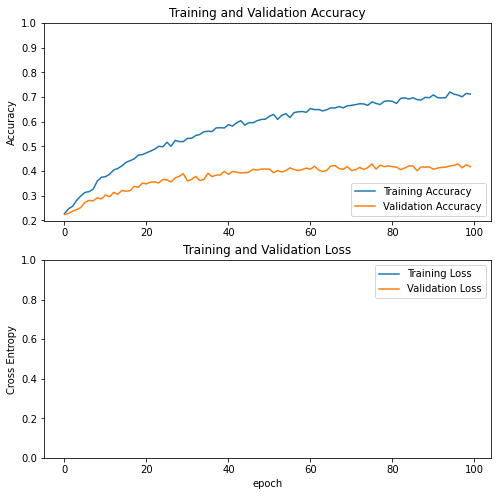

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [37]:
print("Number of layers: {}".format(len(base_model.layers)))

Number of layers: 154


In [38]:
#Fine tune to improve performance further
# Fine-tune from this layer onwards
fine_tune_at = 100

In [39]:
base_model.trainable = True

In [40]:
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainnable = False

In [44]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10)
    , loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    , metrics = ['accuracy']
)

In [45]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [46]:
fine_tune_epochs = 100
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 100/200
  9/149 [>.............................] - ETA: 5:55 - loss: 1.0884 - accuracy: 0.7188

2021-11-16 15:15:27.367031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:25 - loss: 1.0307 - accuracy: 0.7210

2021-11-16 15:19:33.331477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:10 - loss: 1.0295 - accuracy: 0.7216

2021-11-16 15:19:46.012698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 1.0327 - accuracy: 0.7178

2021-11-16 15:20:53.021806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 15:20:58.589963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 365s 2s/step - loss: 1.0327 - accuracy: 0.7178 - val_loss: 2.2633 - val_accuracy: 0.4405
Epoch 101/200
  9/149 [>.............................] - ETA: 5:13 - loss: 0.8932 - accuracy: 0.7396

2021-11-16 15:21:45.450844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:26 - loss: 0.9100 - accuracy: 0.7447

2021-11-16 15:31:57.539727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:12 - loss: 0.9086 - accuracy: 0.7455

2021-11-16 15:32:11.980879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.8991 - accuracy: 0.7504

2021-11-16 15:33:17.965002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 15:33:23.799118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 362s 2s/step - loss: 0.8991 - accuracy: 0.7504 - val_loss: 2.2050 - val_accuracy: 0.4513
Epoch 103/200
  9/149 [>.............................] - ETA: 5:00 - loss: 0.8508 - accuracy: 0.7500

2021-11-16 15:34:07.165064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:19 - loss: 0.8787 - accuracy: 0.7459

2021-11-16 15:37:58.266008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:06 - loss: 0.8760 - accuracy: 0.7471

2021-11-16 15:38:10.506591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.8817 - accuracy: 0.7468

2021-11-16 15:39:17.472011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 15:39:23.283198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 339s 2s/step - loss: 0.8817 - accuracy: 0.7468 - val_loss: 2.1454 - val_accuracy: 0.4533
Epoch 104/200
  9/149 [>.............................] - ETA: 5:52 - loss: 0.9079 - accuracy: 0.7569

2021-11-16 15:40:30.658085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:21 - loss: 0.8605 - accuracy: 0.7517

2021-11-16 15:44:25.657701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:08 - loss: 0.8604 - accuracy: 0.7518

2021-11-16 15:44:41.124439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.8554 - accuracy: 0.7521

2021-11-16 15:45:47.562185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 15:45:53.003559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 346s 2s/step - loss: 0.8554 - accuracy: 0.7521 - val_loss: 2.0564 - val_accuracy: 0.4759
Epoch 105/200
  9/149 [>.............................] - ETA: 5:32 - loss: 0.8532 - accuracy: 0.7674

2021-11-16 15:46:52.564472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:23 - loss: 0.8249 - accuracy: 0.7652

2021-11-16 15:50:54.301133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:09 - loss: 0.8229 - accuracy: 0.7658

2021-11-16 15:51:07.114520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.8157 - accuracy: 0.7670

2021-11-16 15:52:15.761255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 15:52:21.600643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 353s 2s/step - loss: 0.8157 - accuracy: 0.7670 - val_loss: 2.0989 - val_accuracy: 0.4582
Epoch 106/200
  9/149 [>.............................] - ETA: 5:30 - loss: 0.8383 - accuracy: 0.7674

2021-11-16 15:53:14.159611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:25 - loss: 0.7656 - accuracy: 0.7807

2021-11-16 15:57:19.853872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:10 - loss: 0.7696 - accuracy: 0.7807

2021-11-16 15:57:33.221242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.7693 - accuracy: 0.7818

2021-11-16 15:58:41.373110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 15:58:47.433827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 357s 2s/step - loss: 0.7693 - accuracy: 0.7818 - val_loss: 2.0578 - val_accuracy: 0.4907
Epoch 107/200
  9/149 [>.............................] - ETA: 5:08 - loss: 0.8946 - accuracy: 0.7153

2021-11-16 15:59:10.641929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:24 - loss: 0.7087 - accuracy: 0.7945

2021-11-16 16:09:37.430463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:10 - loss: 0.7209 - accuracy: 0.7910

2021-11-16 16:09:50.699579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.7187 - accuracy: 0.7910

2021-11-16 16:11:04.565592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 16:11:10.313544: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 361s 2s/step - loss: 0.7187 - accuracy: 0.7910 - val_loss: 2.1071 - val_accuracy: 0.4848
Epoch 109/200
  9/149 [>.............................] - ETA: 5:38 - loss: 0.6469 - accuracy: 0.8194

2021-11-16 16:11:34.662669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:27 - loss: 0.6740 - accuracy: 0.8028

2021-11-16 16:15:47.574797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:24 - loss: 0.6636 - accuracy: 0.8114

2021-11-16 16:22:01.205666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:10 - loss: 0.6613 - accuracy: 0.8107

2021-11-16 16:22:14.239553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.6672 - accuracy: 0.8104

2021-11-16 16:23:23.513326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 16:23:29.129899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 357s 2s/step - loss: 0.6672 - accuracy: 0.8104 - val_loss: 2.0696 - val_accuracy: 0.4995
Epoch 111/200
  9/149 [>.............................] - ETA: 5:00 - loss: 0.6230 - accuracy: 0.7986

2021-11-16 16:23:51.657812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:21 - loss: 0.6386 - accuracy: 0.8150

2021-11-16 16:27:49.623051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:08 - loss: 0.6388 - accuracy: 0.8149

2021-11-16 16:28:05.175321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.6364 - accuracy: 0.8180

2021-11-16 16:29:15.311494: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 16:29:21.301581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 352s 2s/step - loss: 0.6364 - accuracy: 0.8180 - val_loss: 2.0541 - val_accuracy: 0.4936
Epoch 112/200
  9/149 [>.............................] - ETA: 5:11 - loss: 0.5501 - accuracy: 0.8542

2021-11-16 16:29:45.134683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:22 - loss: 0.6209 - accuracy: 0.8230

2021-11-16 16:33:43.739119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:08 - loss: 0.6220 - accuracy: 0.8233

2021-11-16 16:33:57.083465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.6218 - accuracy: 0.8241

2021-11-16 16:35:08.587929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 16:35:14.302207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 353s 2s/step - loss: 0.6218 - accuracy: 0.8241 - val_loss: 2.0688 - val_accuracy: 0.4838
Epoch 113/200
  9/149 [>.............................] - ETA: 5:54 - loss: 0.5959 - accuracy: 0.8056

2021-11-16 16:35:39.887762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - ETA: 0s - loss: 0.6116 - accuracy: 0.8226

2021-11-16 16:41:10.009768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 16:41:15.895952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 362s 2s/step - loss: 0.6116 - accuracy: 0.8226 - val_loss: 1.9911 - val_accuracy: 0.5074
Epoch 114/200
  9/149 [>.............................] - ETA: 5:35 - loss: 0.7022 - accuracy: 0.8056

2021-11-16 16:41:40.253640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:25 - loss: 0.5966 - accuracy: 0.8283

2021-11-16 16:45:45.748370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:11 - loss: 0.5966 - accuracy: 0.8277

2021-11-16 16:46:01.220256: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.5824 - accuracy: 0.8327

2021-11-16 16:47:08.456828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 16:47:14.447719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 359s 2s/step - loss: 0.5824 - accuracy: 0.8327 - val_loss: 2.0372 - val_accuracy: 0.5172
Epoch 115/200
  9/149 [>.............................] - ETA: 5:44 - loss: 0.5820 - accuracy: 0.8229

2021-11-16 16:47:40.909711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:23 - loss: 0.5737 - accuracy: 0.8346

2021-11-16 16:51:42.531803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:09 - loss: 0.5740 - accuracy: 0.8338

2021-11-16 16:51:56.214582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.5756 - accuracy: 0.8321

2021-11-16 16:53:02.463447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 16:53:08.507207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 353s 2s/step - loss: 0.5756 - accuracy: 0.8321 - val_loss: 1.9681 - val_accuracy: 0.5123
Epoch 116/200
  9/149 [>.............................] - ETA: 4:14 - loss: 0.5951 - accuracy: 0.8194

2021-11-16 16:53:56.337134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - ETA: 0s - loss: 0.5451 - accuracy: 0.8392

2021-11-16 16:59:25.552978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 16:59:31.366406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 354s 2s/step - loss: 0.5451 - accuracy: 0.8392 - val_loss: 2.1036 - val_accuracy: 0.4828
Epoch 117/200
  9/149 [>.............................] - ETA: 5:34 - loss: 0.5531 - accuracy: 0.8264

2021-11-16 16:59:55.663306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:23 - loss: 0.5417 - accuracy: 0.8424

2021-11-16 17:03:56.388117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:09 - loss: 0.5416 - accuracy: 0.8435

2021-11-16 17:04:09.475985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.5317 - accuracy: 0.8470

2021-11-16 17:05:14.989560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 17:05:21.028966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 350s 2s/step - loss: 0.5317 - accuracy: 0.8470 - val_loss: 1.9852 - val_accuracy: 0.5211
Epoch 118/200
  9/149 [>.............................] - ETA: 5:56 - loss: 0.5338 - accuracy: 0.8472

2021-11-16 17:06:18.009914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:26 - loss: 0.5181 - accuracy: 0.8462

2021-11-16 17:10:27.091606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:12 - loss: 0.5158 - accuracy: 0.8464

2021-11-16 17:10:41.285197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.5164 - accuracy: 0.8430

2021-11-16 17:11:49.014541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 17:11:54.913086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 362s 2s/step - loss: 0.5164 - accuracy: 0.8430 - val_loss: 1.9595 - val_accuracy: 0.5221
Epoch 119/200
  9/149 [>.............................] - ETA: 5:09 - loss: 0.4865 - accuracy: 0.8646

2021-11-16 17:12:18.288912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:20 - loss: 0.4872 - accuracy: 0.8570

2021-11-16 17:16:11.609128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:07 - loss: 0.4841 - accuracy: 0.8574

2021-11-16 17:16:26.828561: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.4879 - accuracy: 0.8548

2021-11-16 17:17:35.125996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 17:17:41.026433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 346s 2s/step - loss: 0.4879 - accuracy: 0.8548 - val_loss: 1.9879 - val_accuracy: 0.5133
Epoch 120/200
  9/149 [>.............................] - ETA: 5:22 - loss: 0.5147 - accuracy: 0.8368

2021-11-16 17:18:40.766540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:24 - loss: 0.4672 - accuracy: 0.8634

2021-11-16 17:29:06.041792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:09 - loss: 0.4656 - accuracy: 0.8640

2021-11-16 17:29:19.185358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.4618 - accuracy: 0.8672

2021-11-16 17:30:28.436838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 17:30:34.238960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 356s 2s/step - loss: 0.4618 - accuracy: 0.8672 - val_loss: 1.9582 - val_accuracy: 0.5162
Epoch 122/200
  9/149 [>.............................] - ETA: 5:26 - loss: 0.4747 - accuracy: 0.8507

2021-11-16 17:30:58.419791: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:25 - loss: 0.4486 - accuracy: 0.8639

2021-11-16 17:35:04.534918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:11 - loss: 0.4474 - accuracy: 0.8642

2021-11-16 17:35:20.201362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.4485 - accuracy: 0.8655

2021-11-16 17:36:27.797936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 17:36:33.423065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 359s 2s/step - loss: 0.4485 - accuracy: 0.8655 - val_loss: 2.0753 - val_accuracy: 0.5084
Epoch 123/200
  9/149 [>.............................] - ETA: 5:31 - loss: 0.4601 - accuracy: 0.8750

2021-11-16 17:36:58.251410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:22 - loss: 0.4414 - accuracy: 0.8722

2021-11-16 17:40:57.500133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:22 - loss: 0.4013 - accuracy: 0.8805

2021-11-16 17:47:19.321621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:09 - loss: 0.4017 - accuracy: 0.8800

2021-11-16 17:47:33.579364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.4013 - accuracy: 0.8809

2021-11-16 17:48:46.871096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 17:48:52.525104: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 357s 2s/step - loss: 0.4013 - accuracy: 0.8809 - val_loss: 1.9486 - val_accuracy: 0.5221
Epoch 125/200
  9/149 [>.............................] - ETA: 5:23 - loss: 0.4705 - accuracy: 0.8785

2021-11-16 17:49:40.514744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:24 - loss: 0.4141 - accuracy: 0.8769

2021-11-16 17:53:44.145550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:10 - loss: 0.4191 - accuracy: 0.8758

2021-11-16 17:53:58.860057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.4121 - accuracy: 0.8773

2021-11-16 17:55:14.205202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 17:55:20.167747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 363s 2s/step - loss: 0.4121 - accuracy: 0.8773 - val_loss: 1.9524 - val_accuracy: 0.5320
Epoch 126/200
  9/149 [>.............................] - ETA: 6:15 - loss: 0.4581 - accuracy: 0.8542

2021-11-16 17:55:47.095576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:25 - loss: 0.3849 - accuracy: 0.8894

2021-11-16 17:59:52.775048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:11 - loss: 0.3813 - accuracy: 0.8905

2021-11-16 18:00:05.922773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.3866 - accuracy: 0.8887

2021-11-16 18:01:14.070183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 18:01:19.897792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 359s 2s/step - loss: 0.3866 - accuracy: 0.8887 - val_loss: 2.0382 - val_accuracy: 0.5064
Epoch 127/200
  9/149 [>.............................] - ETA: 4:50 - loss: 0.3528 - accuracy: 0.8958

2021-11-16 18:01:40.690291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:23 - loss: 0.3964 - accuracy: 0.8858

2021-11-16 18:05:44.016427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:26 - loss: 0.3888 - accuracy: 0.8811

2021-11-16 18:11:43.805800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:11 - loss: 0.3889 - accuracy: 0.8821

2021-11-16 18:11:58.422275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.3828 - accuracy: 0.8851

2021-11-16 18:13:12.927789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 18:13:18.664320: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 367s 2s/step - loss: 0.3828 - accuracy: 0.8851 - val_loss: 2.0097 - val_accuracy: 0.5310
Epoch 129/200
  9/149 [>.............................] - ETA: 5:15 - loss: 0.3608 - accuracy: 0.9028

2021-11-16 18:13:55.682651: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/149 [>.............................] - ETA: 5:32 - loss: 0.4255 - accuracy: 0.8819

2021-11-16 18:20:19.711788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:23 - loss: 0.3564 - accuracy: 0.8968

2021-11-16 18:24:21.510984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:09 - loss: 0.3559 - accuracy: 0.8976

2021-11-16 18:24:35.818937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.3518 - accuracy: 0.8981

2021-11-16 18:25:46.360582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 18:25:52.419927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - ETA: 0s - loss: 0.3472 - accuracy: 0.8977

2021-11-16 18:32:07.892567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 18:32:13.794403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 357s 2s/step - loss: 0.3472 - accuracy: 0.8977 - val_loss: 1.9399 - val_accuracy: 0.5241
Epoch 132/200
  9/149 [>.............................] - ETA: 6:14 - loss: 0.3543 - accuracy: 0.8958

2021-11-16 18:33:04.756776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:22 - loss: 0.3053 - accuracy: 0.9068

2021-11-16 18:37:00.637987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:09 - loss: 0.3121 - accuracy: 0.9044

2021-11-16 18:37:16.347999: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.3138 - accuracy: 0.9040

2021-11-16 18:38:26.082970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 18:38:31.874421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 353s 2s/step - loss: 0.3138 - accuracy: 0.9040 - val_loss: 2.1038 - val_accuracy: 0.5221
Epoch 133/200
  9/149 [>.............................] - ETA: 5:04 - loss: 0.3714 - accuracy: 0.8958

2021-11-16 18:39:23.258650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:20 - loss: 0.3202 - accuracy: 0.9015

2021-11-16 18:43:17.800232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:08 - loss: 0.3218 - accuracy: 0.9018

2021-11-16 18:43:33.650746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.3206 - accuracy: 0.9036

2021-11-16 18:44:44.873071: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 18:44:50.557787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 350s 2s/step - loss: 0.3206 - accuracy: 0.9036 - val_loss: 1.9798 - val_accuracy: 0.5359
Epoch 134/200
  9/149 [>.............................] - ETA: 5:22 - loss: 0.3934 - accuracy: 0.8889

2021-11-16 18:45:14.725172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:25 - loss: 0.3178 - accuracy: 0.9085

2021-11-16 18:49:23.481501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:11 - loss: 0.3196 - accuracy: 0.9081

2021-11-16 18:49:37.457787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.3151 - accuracy: 0.9110

2021-11-16 18:50:42.482159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 18:50:48.245234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 358s 2s/step - loss: 0.3151 - accuracy: 0.9110 - val_loss: 1.9485 - val_accuracy: 0.5398
Epoch 135/200
  9/149 [>.............................] - ETA: 5:25 - loss: 0.3828 - accuracy: 0.8681

2021-11-16 18:51:36.756437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:23 - loss: 0.3149 - accuracy: 0.9112

2021-11-16 18:55:39.131512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:09 - loss: 0.3139 - accuracy: 0.9102

2021-11-16 18:55:51.791145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.3074 - accuracy: 0.9122

2021-11-16 18:57:01.453557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 18:57:06.955354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 354s 2s/step - loss: 0.3074 - accuracy: 0.9122 - val_loss: 2.0005 - val_accuracy: 0.5251
Epoch 136/200
  9/149 [>.............................] - ETA: 5:41 - loss: 0.2563 - accuracy: 0.9340

2021-11-16 18:57:31.858004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:24 - loss: 0.3054 - accuracy: 0.9143

2021-11-16 19:01:36.412408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:10 - loss: 0.3042 - accuracy: 0.9144

2021-11-16 19:01:51.351397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.3024 - accuracy: 0.9146

2021-11-16 19:02:58.503371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 19:03:04.116101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 357s 2s/step - loss: 0.3024 - accuracy: 0.9146 - val_loss: 2.0353 - val_accuracy: 0.5211
Epoch 137/200
  9/149 [>.............................] - ETA: 5:32 - loss: 0.2782 - accuracy: 0.9201

2021-11-16 19:03:52.400602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:24 - loss: 0.3048 - accuracy: 0.9115

2021-11-16 19:07:56.093948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:10 - loss: 0.3032 - accuracy: 0.9123

2021-11-16 19:08:09.053933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.2976 - accuracy: 0.9137

2021-11-16 19:09:17.056164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 19:09:22.768389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 354s 2s/step - loss: 0.2976 - accuracy: 0.9137 - val_loss: 1.9830 - val_accuracy: 0.5339
Epoch 138/200
  9/149 [>.............................] - ETA: 5:02 - loss: 0.2914 - accuracy: 0.9167

2021-11-16 19:10:12.684271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:25 - loss: 0.3009 - accuracy: 0.9126

2021-11-16 19:14:20.678542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:10 - loss: 0.3025 - accuracy: 0.9131

2021-11-16 19:14:34.241116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.3035 - accuracy: 0.9125

2021-11-16 19:15:44.058529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 19:15:49.846697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 359s 2s/step - loss: 0.3035 - accuracy: 0.9125 - val_loss: 2.0009 - val_accuracy: 0.5202
Epoch 139/200
  9/149 [>.............................] - ETA: 5:44 - loss: 0.2359 - accuracy: 0.9236

2021-11-16 19:16:37.536624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:23 - loss: 0.2838 - accuracy: 0.9198

2021-11-16 19:20:39.109055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:09 - loss: 0.2840 - accuracy: 0.9194

2021-11-16 19:20:52.703403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.2773 - accuracy: 0.9209

2021-11-16 19:22:06.353209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 19:22:12.104132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 359s 2s/step - loss: 0.2773 - accuracy: 0.9209 - val_loss: 1.9784 - val_accuracy: 0.5379
Epoch 140/200
  9/149 [>.............................] - ETA: 4:51 - loss: 0.2501 - accuracy: 0.9375

2021-11-16 19:22:34.266174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:20 - loss: 0.2687 - accuracy: 0.9209

2021-11-16 19:26:29.480153: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:07 - loss: 0.2692 - accuracy: 0.9204

2021-11-16 19:26:42.232996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.2783 - accuracy: 0.9169

2021-11-16 19:27:48.561194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 19:27:54.484319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 343s 2s/step - loss: 0.2783 - accuracy: 0.9169 - val_loss: 2.0163 - val_accuracy: 0.5329
Epoch 141/200
  9/149 [>.............................] - ETA: 5:52 - loss: 0.2993 - accuracy: 0.9028

2021-11-16 19:28:59.306248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:23 - loss: 0.2652 - accuracy: 0.9190

2021-11-16 19:39:22.670639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:10 - loss: 0.2660 - accuracy: 0.9189

2021-11-16 19:39:37.370961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.2659 - accuracy: 0.9198

2021-11-16 19:40:47.326220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 19:40:53.447582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 358s 2s/step - loss: 0.2659 - accuracy: 0.9198 - val_loss: 1.9642 - val_accuracy: 0.5349
Epoch 143/200
  9/149 [>.............................] - ETA: 5:05 - loss: 0.3218 - accuracy: 0.8924

2021-11-16 19:41:16.645704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:20 - loss: 0.2617 - accuracy: 0.9192

2021-11-16 19:45:10.502132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:07 - loss: 0.2652 - accuracy: 0.9186

2021-11-16 19:45:23.082498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.2585 - accuracy: 0.9217

2021-11-16 19:46:31.350580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 19:46:37.175691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 344s 2s/step - loss: 0.2585 - accuracy: 0.9217 - val_loss: 2.0154 - val_accuracy: 0.5320
Epoch 144/200
  9/149 [>.............................] - ETA: 6:04 - loss: 0.2585 - accuracy: 0.9271

2021-11-16 19:47:40.583702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:26 - loss: 0.2377 - accuracy: 0.9339

2021-11-16 19:51:49.686795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:12 - loss: 0.2407 - accuracy: 0.9328

2021-11-16 19:52:03.578675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.2410 - accuracy: 0.9308

2021-11-16 19:53:11.383361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 19:53:17.060773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 362s 2s/step - loss: 0.2410 - accuracy: 0.9308 - val_loss: 1.9688 - val_accuracy: 0.5556
Epoch 145/200
  9/149 [>.............................] - ETA: 5:41 - loss: 0.2125 - accuracy: 0.9340

2021-11-16 19:53:42.241927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:24 - loss: 0.2345 - accuracy: 0.9300

2021-11-16 19:57:45.982610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:10 - loss: 0.2340 - accuracy: 0.9307

2021-11-16 19:58:00.525604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.2380 - accuracy: 0.9308

2021-11-16 19:59:08.626926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 19:59:14.265609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 357s 2s/step - loss: 0.2380 - accuracy: 0.9308 - val_loss: 1.9897 - val_accuracy: 0.5487
Epoch 146/200
  9/149 [>.............................] - ETA: 5:16 - loss: 0.2265 - accuracy: 0.9236

2021-11-16 20:00:02.266752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:24 - loss: 0.2392 - accuracy: 0.9306

2021-11-16 20:04:07.222948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:10 - loss: 0.2405 - accuracy: 0.9304

2021-11-16 20:04:21.299185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.2452 - accuracy: 0.9276

2021-11-16 20:05:26.992358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 20:05:32.679531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 354s 2s/step - loss: 0.2452 - accuracy: 0.9276 - val_loss: 2.0172 - val_accuracy: 0.5241
Epoch 147/200
  9/149 [>.............................] - ETA: 5:39 - loss: 0.2318 - accuracy: 0.9271

2021-11-16 20:05:57.591027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:25 - loss: 0.2414 - accuracy: 0.9287

2021-11-16 20:10:04.318130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:11 - loss: 0.2402 - accuracy: 0.9291

2021-11-16 20:10:19.100981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.2329 - accuracy: 0.9320

2021-11-16 20:11:29.331543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 20:11:34.901017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 362s 2s/step - loss: 0.2329 - accuracy: 0.9320 - val_loss: 1.9431 - val_accuracy: 0.5516
Epoch 148/200
  9/149 [>.............................] - ETA: 5:49 - loss: 0.2149 - accuracy: 0.9410

2021-11-16 20:12:00.737981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:25 - loss: 0.2147 - accuracy: 0.9425

2021-11-16 20:16:07.120945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:11 - loss: 0.2158 - accuracy: 0.9414

2021-11-16 20:16:21.498204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.2209 - accuracy: 0.9392

2021-11-16 20:17:26.042806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 20:17:31.770676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 357s 2s/step - loss: 0.2209 - accuracy: 0.9392 - val_loss: 2.0274 - val_accuracy: 0.5556
Epoch 149/200
  9/149 [>.............................] - ETA: 5:58 - loss: 0.2189 - accuracy: 0.9306

2021-11-16 20:18:23.126642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:23 - loss: 0.2184 - accuracy: 0.9386

2021-11-16 20:22:21.623718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:08 - loss: 0.2190 - accuracy: 0.9380

2021-11-16 20:22:32.677476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.2172 - accuracy: 0.9371

2021-11-16 20:23:41.502908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 20:23:47.086988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 350s 2s/step - loss: 0.2172 - accuracy: 0.9371 - val_loss: 2.0466 - val_accuracy: 0.5497
Epoch 150/200
  9/149 [>.............................] - ETA: 5:15 - loss: 0.2279 - accuracy: 0.9201

2021-11-16 20:24:41.876647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:24 - loss: 0.2159 - accuracy: 0.9292

2021-11-16 20:28:45.548706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:10 - loss: 0.2191 - accuracy: 0.9278

2021-11-16 20:29:00.741738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.2182 - accuracy: 0.9312

2021-11-16 20:30:09.915124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 20:30:15.474100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 356s 2s/step - loss: 0.2182 - accuracy: 0.9312 - val_loss: 1.9632 - val_accuracy: 0.5624
Epoch 151/200
  9/149 [>.............................] - ETA: 5:15 - loss: 0.2559 - accuracy: 0.9306

2021-11-16 20:31:04.321200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:21 - loss: 0.2046 - accuracy: 0.9403

2021-11-16 20:35:00.074303: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:07 - loss: 0.2094 - accuracy: 0.9375

2021-11-16 20:35:13.378442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.2024 - accuracy: 0.9402

2021-11-16 20:36:23.361376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 20:36:28.892725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 348s 2s/step - loss: 0.2024 - accuracy: 0.9402 - val_loss: 1.9539 - val_accuracy: 0.5615
Epoch 152/200
  9/149 [>.............................] - ETA: 5:12 - loss: 0.2247 - accuracy: 0.9306

2021-11-16 20:36:52.643674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:25 - loss: 0.1972 - accuracy: 0.9439

2021-11-16 20:40:59.929759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:11 - loss: 0.1986 - accuracy: 0.9433

2021-11-16 20:41:15.493823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.1987 - accuracy: 0.9432

2021-11-16 20:42:25.847376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 20:42:31.610616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 363s 2s/step - loss: 0.1987 - accuracy: 0.9432 - val_loss: 1.9525 - val_accuracy: 0.5526
Epoch 153/200
  9/149 [>.............................] - ETA: 5:38 - loss: 0.2157 - accuracy: 0.9340

2021-11-16 20:43:16.022906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:24 - loss: 0.2017 - accuracy: 0.9411

2021-11-16 20:47:20.055604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:10 - loss: 0.2053 - accuracy: 0.9399

2021-11-16 20:47:33.718314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.2082 - accuracy: 0.9394

2021-11-16 20:48:42.091781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 20:48:47.871564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 357s 2s/step - loss: 0.2082 - accuracy: 0.9394 - val_loss: 2.0105 - val_accuracy: 0.5428
Epoch 154/200
  9/149 [>.............................] - ETA: 5:11 - loss: 0.2054 - accuracy: 0.9375

2021-11-16 20:49:36.422491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:25 - loss: 0.1880 - accuracy: 0.9422

2021-11-16 20:53:46.138767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:11 - loss: 0.1882 - accuracy: 0.9422

2021-11-16 20:54:00.867403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.1889 - accuracy: 0.9413

2021-11-16 20:55:13.208322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 20:55:19.359725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 366s 2s/step - loss: 0.1889 - accuracy: 0.9413 - val_loss: 1.9911 - val_accuracy: 0.5497
Epoch 155/200
  9/149 [>.............................] - ETA: 4:58 - loss: 0.2070 - accuracy: 0.9306

2021-11-16 20:55:42.150796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:24 - loss: 0.1892 - accuracy: 0.9469

2021-11-16 20:59:49.083509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:10 - loss: 0.1924 - accuracy: 0.9456

2021-11-16 21:00:02.829667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.1918 - accuracy: 0.9459

2021-11-16 21:01:09.688147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 21:01:15.513731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 356s 2s/step - loss: 0.1918 - accuracy: 0.9459 - val_loss: 2.0186 - val_accuracy: 0.5536
Epoch 156/200
  9/149 [>.............................] - ETA: 5:50 - loss: 0.1775 - accuracy: 0.9514

2021-11-16 21:02:06.166374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:25 - loss: 0.1846 - accuracy: 0.9483

2021-11-16 21:12:12.640367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:11 - loss: 0.1835 - accuracy: 0.9483

2021-11-16 21:12:26.947474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.1869 - accuracy: 0.9470

2021-11-16 21:13:35.738208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 21:13:41.542256: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 361s 2s/step - loss: 0.1869 - accuracy: 0.9470 - val_loss: 2.0181 - val_accuracy: 0.5418
Epoch 158/200
  9/149 [>.............................] - ETA: 5:12 - loss: 0.1973 - accuracy: 0.9271

2021-11-16 21:14:26.322454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:24 - loss: 0.1951 - accuracy: 0.9372

2021-11-16 21:18:31.358188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:10 - loss: 0.1943 - accuracy: 0.9380

2021-11-16 21:18:44.392953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.1918 - accuracy: 0.9398

2021-11-16 21:19:55.213050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 21:20:00.751388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 358s 2s/step - loss: 0.1918 - accuracy: 0.9398 - val_loss: 2.0268 - val_accuracy: 0.5624
Epoch 159/200
  9/149 [>.............................] - ETA: 5:16 - loss: 0.1603 - accuracy: 0.9479

2021-11-16 21:20:48.425728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:23 - loss: 0.1773 - accuracy: 0.9488

2021-11-16 21:24:50.095426: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:09 - loss: 0.1770 - accuracy: 0.9485

2021-11-16 21:25:03.271080: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.1772 - accuracy: 0.9478

2021-11-16 21:26:12.567343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 21:26:18.231672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 353s 2s/step - loss: 0.1772 - accuracy: 0.9478 - val_loss: 2.0050 - val_accuracy: 0.5703
Epoch 160/200
  9/149 [>.............................] - ETA: 5:37 - loss: 0.1878 - accuracy: 0.9444

2021-11-16 21:26:42.752251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:24 - loss: 0.1636 - accuracy: 0.9527

2021-11-16 21:30:46.043379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:10 - loss: 0.1665 - accuracy: 0.9519

2021-11-16 21:31:00.823376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.1716 - accuracy: 0.9516

2021-11-16 21:32:11.176628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 21:32:17.029117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 359s 2s/step - loss: 0.1716 - accuracy: 0.9516 - val_loss: 2.0420 - val_accuracy: 0.5565
Epoch 161/200
  9/149 [>.............................] - ETA: 6:16 - loss: 0.1951 - accuracy: 0.9410

2021-11-16 21:33:06.226850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/149 [>.............................] - ETA: 4:45 - loss: 0.1656 - accuracy: 0.9479

2021-11-16 21:38:52.212494: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:25 - loss: 0.1591 - accuracy: 0.9505

2021-11-16 21:43:01.642441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:11 - loss: 0.1569 - accuracy: 0.9519

2021-11-16 21:43:17.469704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.1628 - accuracy: 0.9491

2021-11-16 21:44:26.014407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 21:44:32.025138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 361s 2s/step - loss: 0.1628 - accuracy: 0.9491 - val_loss: 2.0270 - val_accuracy: 0.5546
Epoch 163/200
  9/149 [>.............................] - ETA: 5:43 - loss: 0.1806 - accuracy: 0.9271

2021-11-16 21:45:18.826344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:23 - loss: 0.1653 - accuracy: 0.9480

2021-11-16 21:49:20.482670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:10 - loss: 0.1646 - accuracy: 0.9475

2021-11-16 21:49:35.273594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.1614 - accuracy: 0.9499

2021-11-16 21:50:42.937311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 21:50:48.587760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 355s 2s/step - loss: 0.1614 - accuracy: 0.9499 - val_loss: 2.0070 - val_accuracy: 0.5595
Epoch 164/200
  9/149 [>.............................] - ETA: 6:21 - loss: 0.1477 - accuracy: 0.9653

2021-11-16 21:51:42.631029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:28 - loss: 0.1511 - accuracy: 0.9574

2021-11-16 21:55:56.051050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:13 - loss: 0.1544 - accuracy: 0.9564

2021-11-16 21:56:09.763608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.1596 - accuracy: 0.9543

2021-11-16 21:57:16.025221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 21:57:21.662007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 366s 2s/step - loss: 0.1596 - accuracy: 0.9543 - val_loss: 1.9480 - val_accuracy: 0.5683
Epoch 165/200
  9/149 [>.............................] - ETA: 5:23 - loss: 0.1530 - accuracy: 0.9444

2021-11-16 21:57:44.542734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:26 - loss: 0.1722 - accuracy: 0.9513

2021-11-16 22:08:17.038360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:12 - loss: 0.1737 - accuracy: 0.9506

2021-11-16 22:08:32.806201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.1710 - accuracy: 0.9508

2021-11-16 22:09:41.595806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 22:09:47.330430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 364s 2s/step - loss: 0.1710 - accuracy: 0.9508 - val_loss: 2.0626 - val_accuracy: 0.5487
Epoch 167/200
  9/149 [>.............................] - ETA: 4:15 - loss: 0.1501 - accuracy: 0.9618

2021-11-16 22:10:25.144896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:23 - loss: 0.1481 - accuracy: 0.9577

2021-11-16 22:14:29.266792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:09 - loss: 0.1506 - accuracy: 0.9569

2021-11-16 22:14:42.621966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.1554 - accuracy: 0.9545

2021-11-16 22:15:49.017800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 22:15:54.869865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 350s 2s/step - loss: 0.1554 - accuracy: 0.9545 - val_loss: 1.9931 - val_accuracy: 0.5428
Epoch 168/200
  9/149 [>.............................] - ETA: 5:20 - loss: 0.1582 - accuracy: 0.9549

2021-11-16 22:16:19.174933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:25 - loss: 0.1426 - accuracy: 0.9602

2021-11-16 22:20:27.883420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:10 - loss: 0.1426 - accuracy: 0.9603

2021-11-16 22:20:40.011570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.1451 - accuracy: 0.9598

2021-11-16 22:21:52.459902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 22:21:58.346226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 363s 2s/step - loss: 0.1451 - accuracy: 0.9598 - val_loss: 2.0074 - val_accuracy: 0.5634
Epoch 169/200
  9/149 [>.............................] - ETA: 5:30 - loss: 0.1350 - accuracy: 0.9479

2021-11-16 22:22:41.303982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:25 - loss: 0.1509 - accuracy: 0.9552

2021-11-16 22:26:47.606333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:11 - loss: 0.1538 - accuracy: 0.9543

2021-11-16 22:27:01.841687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.1528 - accuracy: 0.9560

2021-11-16 22:28:12.102949: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 22:28:18.013693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 361s 2s/step - loss: 0.1528 - accuracy: 0.9560 - val_loss: 2.0225 - val_accuracy: 0.5683
Epoch 170/200
  9/149 [>.............................] - ETA: 4:37 - loss: 0.1504 - accuracy: 0.9549

2021-11-16 22:28:59.891653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:25 - loss: 0.1325 - accuracy: 0.9616

2021-11-16 22:33:09.052269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:10 - loss: 0.1334 - accuracy: 0.9617

2021-11-16 22:33:20.236482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.1360 - accuracy: 0.9592

2021-11-16 22:34:32.772245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 22:34:38.627579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 359s 2s/step - loss: 0.1360 - accuracy: 0.9592 - val_loss: 2.0478 - val_accuracy: 0.5575
Epoch 171/200
  9/149 [>.............................] - ETA: 4:56 - loss: 0.1750 - accuracy: 0.9410

2021-11-16 22:35:21.953845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - ETA: 0s - loss: 0.1478 - accuracy: 0.9566

2021-11-16 22:40:52.968896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 22:40:58.990418: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 358s 2s/step - loss: 0.1478 - accuracy: 0.9566 - val_loss: 1.9849 - val_accuracy: 0.5752
Epoch 172/200
  9/149 [>.............................] - ETA: 5:03 - loss: 0.1240 - accuracy: 0.9653

2021-11-16 22:41:44.205694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:27 - loss: 0.1320 - accuracy: 0.9593

2021-11-16 22:52:22.154482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:12 - loss: 0.1355 - accuracy: 0.9580

2021-11-16 22:52:35.992683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.1345 - accuracy: 0.9592

2021-11-16 22:53:45.975098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 22:53:51.636566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 367s 2s/step - loss: 0.1345 - accuracy: 0.9592 - val_loss: 1.9851 - val_accuracy: 0.5703
Epoch 174/200
  9/149 [>.............................] - ETA: 4:59 - loss: 0.1227 - accuracy: 0.9722

2021-11-16 22:54:29.053922: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:26 - loss: 0.1389 - accuracy: 0.9621

2021-11-16 22:58:42.103419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:12 - loss: 0.1398 - accuracy: 0.9617

2021-11-16 22:58:55.679459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.1458 - accuracy: 0.9602

2021-11-16 23:00:00.639780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 23:00:06.949309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 360s 2s/step - loss: 0.1458 - accuracy: 0.9602 - val_loss: 2.0694 - val_accuracy: 0.5447
Epoch 175/200
  9/149 [>.............................] - ETA: 5:23 - loss: 0.1082 - accuracy: 0.9688

2021-11-16 23:00:31.138978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:23 - loss: 0.1328 - accuracy: 0.9607

2021-11-16 23:10:54.879440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:10 - loss: 0.1355 - accuracy: 0.9603

2021-11-16 23:11:11.139230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.1326 - accuracy: 0.9606

2021-11-16 23:12:17.602322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 23:12:23.362930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 354s 2s/step - loss: 0.1326 - accuracy: 0.9606 - val_loss: 2.0010 - val_accuracy: 0.5516
Epoch 177/200
  9/149 [>.............................] - ETA: 5:12 - loss: 0.1188 - accuracy: 0.9653

2021-11-16 23:13:14.246134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:22 - loss: 0.1292 - accuracy: 0.9640

2021-11-16 23:17:14.285162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:09 - loss: 0.1278 - accuracy: 0.9651

2021-11-16 23:17:28.470094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.1328 - accuracy: 0.9634

2021-11-16 23:18:32.950086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 23:18:39.739650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 349s 2s/step - loss: 0.1328 - accuracy: 0.9634 - val_loss: 1.9899 - val_accuracy: 0.5733
Epoch 178/200
  9/149 [>.............................] - ETA: 5:09 - loss: 0.1344 - accuracy: 0.9514

2021-11-16 23:19:03.423699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:25 - loss: 0.1221 - accuracy: 0.9654

2021-11-16 23:29:33.211856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:11 - loss: 0.1205 - accuracy: 0.9659

2021-11-16 23:29:46.332710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.1239 - accuracy: 0.9642

2021-11-16 23:30:57.184282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 23:31:03.094616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 361s 2s/step - loss: 0.1239 - accuracy: 0.9642 - val_loss: 2.0338 - val_accuracy: 0.5605
Epoch 180/200
  9/149 [>.............................] - ETA: 5:44 - loss: 0.1065 - accuracy: 0.9653

2021-11-16 23:31:48.421541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:23 - loss: 0.1166 - accuracy: 0.9649

2021-11-16 23:35:50.017855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:10 - loss: 0.1182 - accuracy: 0.9648

2021-11-16 23:36:05.317612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.1204 - accuracy: 0.9636

2021-11-16 23:37:21.576828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 23:37:27.465737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 364s 2s/step - loss: 0.1204 - accuracy: 0.9636 - val_loss: 2.0903 - val_accuracy: 0.5624
Epoch 181/200
  9/149 [>.............................] - ETA: 5:52 - loss: 0.1179 - accuracy: 0.9722

2021-11-16 23:37:53.601562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:24 - loss: 0.1164 - accuracy: 0.9660

2021-11-16 23:41:56.903649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:10 - loss: 0.1175 - accuracy: 0.9648

2021-11-16 23:42:10.419369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.1206 - accuracy: 0.9642

2021-11-16 23:43:23.898920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 23:43:29.722616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 362s 2s/step - loss: 0.1206 - accuracy: 0.9642 - val_loss: 2.0004 - val_accuracy: 0.5801
Epoch 182/200
  9/149 [>.............................] - ETA: 4:51 - loss: 0.1039 - accuracy: 0.9792

2021-11-16 23:43:52.153094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:24 - loss: 0.1167 - accuracy: 0.9688

2021-11-16 23:47:57.133900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:10 - loss: 0.1163 - accuracy: 0.9688

2021-11-16 23:48:11.594268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.1206 - accuracy: 0.9670

2021-11-16 23:49:17.181067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 23:49:22.921002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 353s 2s/step - loss: 0.1206 - accuracy: 0.9670 - val_loss: 1.9355 - val_accuracy: 0.5841
Epoch 183/200
  9/149 [>.............................] - ETA: 5:29 - loss: 0.1728 - accuracy: 0.9514

2021-11-16 23:50:15.256123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:24 - loss: 0.1230 - accuracy: 0.9671

2021-11-16 23:54:18.966641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:10 - loss: 0.1241 - accuracy: 0.9669

2021-11-16 23:54:32.732855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.1255 - accuracy: 0.9642

2021-11-16 23:55:40.143397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-16 23:55:46.063913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 354s 2s/step - loss: 0.1255 - accuracy: 0.9642 - val_loss: 2.0360 - val_accuracy: 0.5683
Epoch 184/200
  9/149 [>.............................] - ETA: 5:49 - loss: 0.0848 - accuracy: 0.9792

2021-11-16 23:56:38.022838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:25 - loss: 0.1140 - accuracy: 0.9682

2021-11-17 00:00:43.464435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:11 - loss: 0.1176 - accuracy: 0.9677

2021-11-17 00:00:58.459531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.1179 - accuracy: 0.9670

2021-11-17 00:02:05.105709: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-17 00:02:11.047633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 357s 2s/step - loss: 0.1179 - accuracy: 0.9670 - val_loss: 2.0288 - val_accuracy: 0.5772
Epoch 185/200
  9/149 [>.............................] - ETA: 5:43 - loss: 0.1193 - accuracy: 0.9722

2021-11-17 00:03:00.863572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:24 - loss: 0.1169 - accuracy: 0.9699

2021-11-17 00:07:05.158956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:10 - loss: 0.1163 - accuracy: 0.9703

2021-11-17 00:07:16.796537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.1204 - accuracy: 0.9672

2021-11-17 00:08:23.120778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-17 00:08:28.835160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 353s 2s/step - loss: 0.1204 - accuracy: 0.9672 - val_loss: 2.1158 - val_accuracy: 0.5506
Epoch 186/200
  9/149 [>.............................] - ETA: 5:07 - loss: 0.1216 - accuracy: 0.9653

2021-11-17 00:09:20.555131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:20 - loss: 0.1126 - accuracy: 0.9654

2021-11-17 00:13:12.517676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:06 - loss: 0.1139 - accuracy: 0.9648

2021-11-17 00:13:25.056268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.1156 - accuracy: 0.9646

2021-11-17 00:14:32.203694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-17 00:14:38.151426: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 341s 2s/step - loss: 0.1156 - accuracy: 0.9646 - val_loss: 2.0061 - val_accuracy: 0.5654
Epoch 187/200
  9/149 [>.............................] - ETA: 5:27 - loss: 0.0989 - accuracy: 0.9722

2021-11-17 00:15:01.233602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:23 - loss: 0.1076 - accuracy: 0.9696

2021-11-17 00:19:01.916521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:09 - loss: 0.1061 - accuracy: 0.9701

2021-11-17 00:19:17.615500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.1105 - accuracy: 0.9680

2021-11-17 00:20:30.350059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-17 00:20:36.279349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 358s 2s/step - loss: 0.1105 - accuracy: 0.9680 - val_loss: 2.0080 - val_accuracy: 0.5723
Epoch 188/200
  9/149 [>.............................] - ETA: 5:20 - loss: 0.1290 - accuracy: 0.9688

2021-11-17 00:21:24.183820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:20 - loss: 0.1046 - accuracy: 0.9688

2021-11-17 00:25:15.084200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:07 - loss: 0.1057 - accuracy: 0.9677

2021-11-17 00:25:30.088082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.1077 - accuracy: 0.9674

2021-11-17 00:26:36.648740: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-17 00:26:42.597881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 343s 2s/step - loss: 0.1077 - accuracy: 0.9674 - val_loss: 2.0243 - val_accuracy: 0.5713
Epoch 189/200
  9/149 [>.............................] - ETA: 5:07 - loss: 0.0919 - accuracy: 0.9688

2021-11-17 00:27:44.904060: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:23 - loss: 0.1024 - accuracy: 0.9690

2021-11-17 00:31:48.365572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:10 - loss: 0.1054 - accuracy: 0.9680

2021-11-17 00:32:03.418549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.1099 - accuracy: 0.9657

2021-11-17 00:33:11.943373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-17 00:33:17.966914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 356s 2s/step - loss: 0.1099 - accuracy: 0.9657 - val_loss: 2.0406 - val_accuracy: 0.5851
Epoch 190/200
  9/149 [>.............................] - ETA: 5:55 - loss: 0.0851 - accuracy: 0.9792

2021-11-17 00:33:43.115801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:28 - loss: 0.1076 - accuracy: 0.9696

2021-11-17 00:37:58.407888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:25 - loss: 0.1167 - accuracy: 0.9627

2021-11-17 00:43:49.342547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:11 - loss: 0.1179 - accuracy: 0.9630

2021-11-17 00:44:02.556714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.1167 - accuracy: 0.9646

2021-11-17 00:45:09.661619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-17 00:45:15.266604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 357s 2s/step - loss: 0.1167 - accuracy: 0.9646 - val_loss: 1.9963 - val_accuracy: 0.5742
Epoch 192/200
  9/149 [>.............................] - ETA: 6:00 - loss: 0.1151 - accuracy: 0.9653

2021-11-17 00:45:41.658716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:24 - loss: 0.1044 - accuracy: 0.9710

2021-11-17 00:49:45.425583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:10 - loss: 0.1052 - accuracy: 0.9709

2021-11-17 00:49:59.552397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.1067 - accuracy: 0.9703

2021-11-17 00:51:13.015734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-17 00:51:18.929658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 364s 2s/step - loss: 0.1067 - accuracy: 0.9703 - val_loss: 2.0308 - val_accuracy: 0.5595
Epoch 193/200
  9/149 [>.............................] - ETA: 5:45 - loss: 0.0948 - accuracy: 0.9757

2021-11-17 00:51:44.865496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:24 - loss: 0.1070 - accuracy: 0.9671

2021-11-17 00:55:48.234051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:10 - loss: 0.1088 - accuracy: 0.9672

2021-11-17 00:56:03.543515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.1100 - accuracy: 0.9678

2021-11-17 00:57:09.977700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-17 00:57:15.833696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 357s 2s/step - loss: 0.1100 - accuracy: 0.9678 - val_loss: 2.0935 - val_accuracy: 0.5605
Epoch 194/200
  9/149 [>.............................] - ETA: 5:44 - loss: 0.0539 - accuracy: 0.9896

2021-11-17 00:57:41.497226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:22 - loss: 0.1029 - accuracy: 0.9701

2021-11-17 01:01:39.233075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:08 - loss: 0.1022 - accuracy: 0.9701

2021-11-17 01:01:52.697183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.1072 - accuracy: 0.9676

2021-11-17 01:03:00.673172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-17 01:03:05.963473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 350s 2s/step - loss: 0.1072 - accuracy: 0.9676 - val_loss: 2.0484 - val_accuracy: 0.5683
Epoch 195/200
  9/149 [>.............................] - ETA: 5:24 - loss: 0.1091 - accuracy: 0.9792

2021-11-17 01:04:01.436169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:23 - loss: 0.1022 - accuracy: 0.9740

2021-11-17 01:08:03.966696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:10 - loss: 0.1019 - accuracy: 0.9737

2021-11-17 01:08:19.158370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.1084 - accuracy: 0.9699

2021-11-17 01:09:23.957642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-17 01:09:29.847803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 352s 2s/step - loss: 0.1084 - accuracy: 0.9699 - val_loss: 2.0078 - val_accuracy: 0.5772
Epoch 196/200
  9/149 [>.............................] - ETA: 4:57 - loss: 0.1294 - accuracy: 0.9688

2021-11-17 01:09:51.758010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:26 - loss: 0.1004 - accuracy: 0.9729

2021-11-17 01:14:03.007746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:12 - loss: 0.1017 - accuracy: 0.9727

2021-11-17 01:14:18.544755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.1036 - accuracy: 0.9729

2021-11-17 01:15:28.956918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-17 01:15:34.775494: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 365s 2s/step - loss: 0.1036 - accuracy: 0.9729 - val_loss: 2.0136 - val_accuracy: 0.5870
Epoch 197/200
  9/149 [>.............................] - ETA: 5:37 - loss: 0.1019 - accuracy: 0.9688

2021-11-17 01:16:15.933836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:24 - loss: 0.0975 - accuracy: 0.9723

2021-11-17 01:20:20.638510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:10 - loss: 0.0968 - accuracy: 0.9727

2021-11-17 01:20:35.340201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.0990 - accuracy: 0.9701

2021-11-17 01:21:45.237857: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-17 01:21:50.823571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 359s 2s/step - loss: 0.0990 - accuracy: 0.9701 - val_loss: 2.0972 - val_accuracy: 0.5723
Epoch 198/200
  9/149 [>.............................] - ETA: 4:51 - loss: 0.1355 - accuracy: 0.9444

2021-11-17 01:22:34.892117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:22 - loss: 0.1018 - accuracy: 0.9690

2021-11-17 01:26:34.354688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:09 - loss: 0.1064 - accuracy: 0.9677

2021-11-17 01:26:49.851624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.1075 - accuracy: 0.9663

2021-11-17 01:28:02.386824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-17 01:28:08.288970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 354s 2s/step - loss: 0.1075 - accuracy: 0.9663 - val_loss: 2.0047 - val_accuracy: 0.5742
Epoch 199/200
  9/149 [>.............................] - ETA: 5:53 - loss: 0.1074 - accuracy: 0.9722

2021-11-17 01:28:33.646567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:24 - loss: 0.0995 - accuracy: 0.9707

2021-11-17 01:32:36.343337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:09 - loss: 0.1017 - accuracy: 0.9701

2021-11-17 01:32:48.226993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.1043 - accuracy: 0.9695

2021-11-17 01:33:59.315210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-17 01:34:05.098764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 357s 2s/step - loss: 0.1043 - accuracy: 0.9695 - val_loss: 2.0743 - val_accuracy: 0.5693
Epoch 200/200
  9/149 [>.............................] - ETA: 4:54 - loss: 0.0838 - accuracy: 0.9722

2021-11-17 01:34:26.363846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 1:22 - loss: 0.0972 - accuracy: 0.9707

2021-11-17 01:38:25.932008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 1:08 - loss: 0.0974 - accuracy: 0.9703

2021-11-17 01:38:39.128121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - ETA: 0s - loss: 0.0993 - accuracy: 0.9689

2021-11-17 01:39:48.879745: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-11-17 01:39:54.649905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/149 [==============================] - 349s 2s/step - loss: 0.0993 - accuracy: 0.9689 - val_loss: 2.0201 - val_accuracy: 0.5782


In [47]:
model.save("YogaModelTransferLearningFineTune.h5")

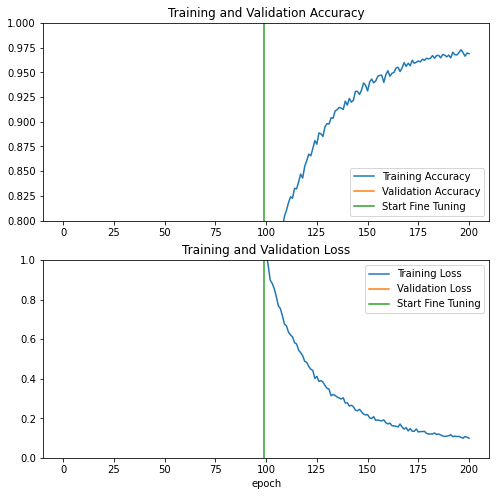

In [52]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [53]:
modelfile = os.path.join(modeldir, 'YogaModelTransferLearningFineTune.h5')
load_model = tf.keras.models.load_model(modelfile)
load_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [54]:
load_model.evaluate(validation_dataset)

2021-11-17 15:07:24.086687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


20/32 [=================>............] - ETA: 3s - loss: 1.8888 - accuracy: 0.5844

2021-11-17 15:07:30.139975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


32/32 [==============================] - 9s 241ms/step - loss: 2.0068 - accuracy: 0.5762


[2.0068044662475586, 0.5762045383453369]

In [55]:
load_model.evaluate(train_dataset)

 10/149 [=>............................] - ETA: 37s - loss: 0.0698 - accuracy: 0.9875

2021-11-17 15:08:15.210924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/149 [=====================>........] - ETA: 9s - loss: 0.0847 - accuracy: 0.9743

2021-11-17 15:08:42.652667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/149 [======================>.......] - ETA: 7s - loss: 0.0842 - accuracy: 0.9745

2021-11-17 15:08:44.017006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


149/149 [==============================] - 39s 261ms/step - loss: 0.0814 - accuracy: 0.9756


[0.08137401193380356, 0.9755892157554626]

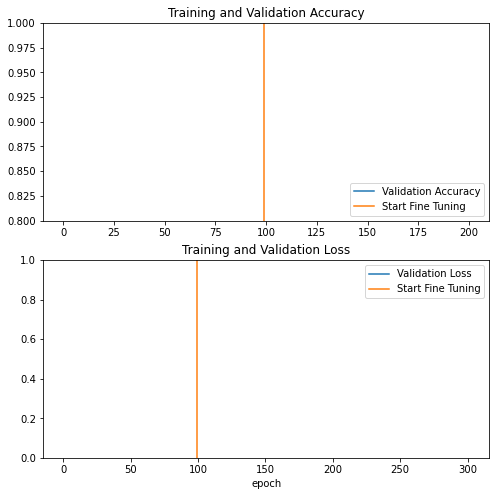

In [59]:


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
#plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
#plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Actual Label: 49
Actual Label Name: marjaryasana
Predicted Label: 49
Predicted Label Name: marjaryasana
#####################
Actual Label: 92
Actual Label Name: uttanasana
Predicted Label: 92
Predicted Label Name: uttanasana
#####################
Actual Label: 14
Actual Label Name: bakasana
Predicted Label: 14
Predicted Label Name: bakasana
#####################
Actual Label: 99
Actual Label Name: viparita karani
Predicted Label: 9
Predicted Label Name: ardha pincha mayurasana
#####################
Actual Label: 82
Actual Label Name: tolasana
Predicted Label: 82
Predicted Label Name: tolasana
#####################
Actual Label: 10
Actual Label Name: ardha uttanasana
Predicted Label: 92
Predicted Label Name: uttanasana
#####################
Actual Label: 68
Actual Label Name: salabhasana
Predicted Label: 68
Predicted Label Name: salabhasana
#####################
Actual Label: 84
Actual Label Name: upavistha konasana
Predicted Label: 50
Predicted Label Name: matsyasana
#################

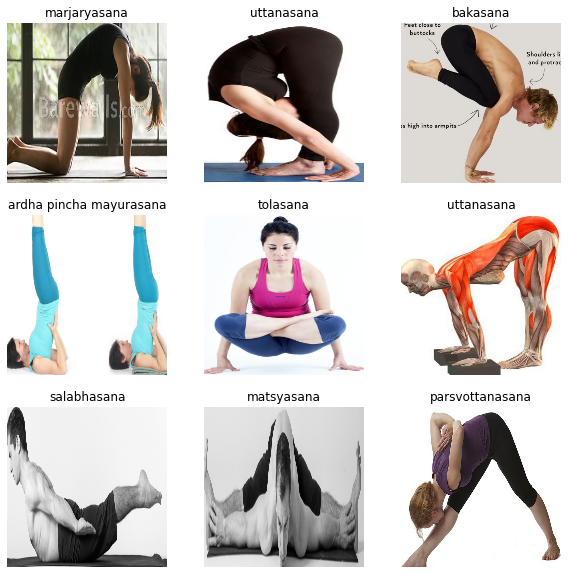

In [80]:
# Retrieve a batch of images from the test set
#image_batch, label_batch = validation_dataset.as_numpy_iterator().next()


plt.figure(figsize=(10, 10))
for i in range(9):
  image = image_batch[i]
  img_array = tf.keras.utils.img_to_array(image)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  label = label_batch[i]
  print ("Actual Label: " + str(label))
  print ("Actual Label Name: " + str(class_names[label]))
  
  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image.astype("uint8"))
  plt.title(class_names[np.argmax(score)])
  plt.axis("off")
    
  print ("Predicted Label: " + str(np.argmax(score)))
  print ("Predicted Label Name: " + str(class_names[np.argmax(score)]))
  print ("#####################")

In [2]:
import os
import tensorflow as tf

modeldir = '/home/jupyter/YogaModel/src'

modelfile = os.path.join(modeldir, 'YogaModelTransferLearningFineTune.h5')
load_model = tf.keras.models.load_model(modelfile)
load_model.summary()

2021-11-18 21:51:11.342318: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-18 21:51:11.345831: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     